In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from pmdarima import auto_arima 
from statsmodels.tsa.stattools import adfuller 
import seaborn as sns 
import warnings 
import pprint
import yfinance as yf
import os 
from pandas.plotting import lag_plot , autocorrelation_plot
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
import tensorflow as tf 
from tensorflow.keras.layers import LSTM , Dense 
from tensorflow.keras.models import Sequential 
from sklearn.preprocessing import MinMaxScaler 
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_percentage_error ,mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima 
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping 




In [2]:
%matplotlib inline 

# ----------
# Plot
# ----------
# graph style
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')

# ----------
# Seaborn rcParams
# ----------
rc={'savefig.dpi': 500,
    'figure.autolayout': True,
    'figure.figsize': [17, 12],
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'font.size': 10,
    'lines.linewidth': 1.0,
    'lines.markersize': 8,
    'legend.fontsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15}

sns.set(context='notebook',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True,
        rc=rc)

# ----------
# Pandas
# ----------
# Floating point
pd.options.display.float_format = '{:.2f}'.format

# Print xxxx rows and all columns
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

# ----------
# Python
# ----------
# pretty print
pp = pprint.PrettyPrinter(indent=4)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

In [3]:
# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

# graph style
sns.set(style='darkgrid', palette='deep')

In [4]:
%%time

# Download historical stock data for Apple (AAPL)
df = yf.download('AAPL', start='2010-07-12', end='2024-07-13')
df.to_csv('AAPL_stock_data.csv')

[*********************100%%**********************]  1 of 1 completed

CPU times: total: 359 ms
Wall time: 2.54 s


In [5]:
os.listdir()

['.ipynb_checkpoints',
 'AAPL_stock_data.csv',
 'apple_stock_forecast.ipynb',
 'workflow.txt']

In [6]:
df=pd.read_csv('AAPL_stock_data.csv',index_col='Date',parse_dates=True)
df

Open   High    Low  Close  Adj Close      Volume
Date                                                         
2010-07-12   9.23   9.35   9.10   9.19       7.77   562878400
2010-07-13   9.15   9.16   8.80   8.99       7.60  1190924000
2010-07-14   8.91   9.14   8.89   9.03       7.63   812047600
2010-07-15   8.87   9.18   8.83   8.98       7.59   824866000
2010-07-16   9.04   9.11   8.87   8.93       7.55  1039858400
...           ...    ...    ...    ...        ...         ...
2024-07-08 227.09 227.85 223.25 227.82     227.82    59085900
2024-07-09 227.93 229.40 226.37 228.68     228.68    48076100
2024-07-10 229.30 233.08 229.25 232.98     232.98    62627700
2024-07-11 231.39 232.39 225.77 227.57     227.57    64710600
2024-07-12 228.92 232.64 228.68 230.54     230.54    53008200

[3525 rows x 6 columns]

In [7]:
df.columns=map(str.lower,df.columns)

In [8]:
df.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume'], dtype='object')

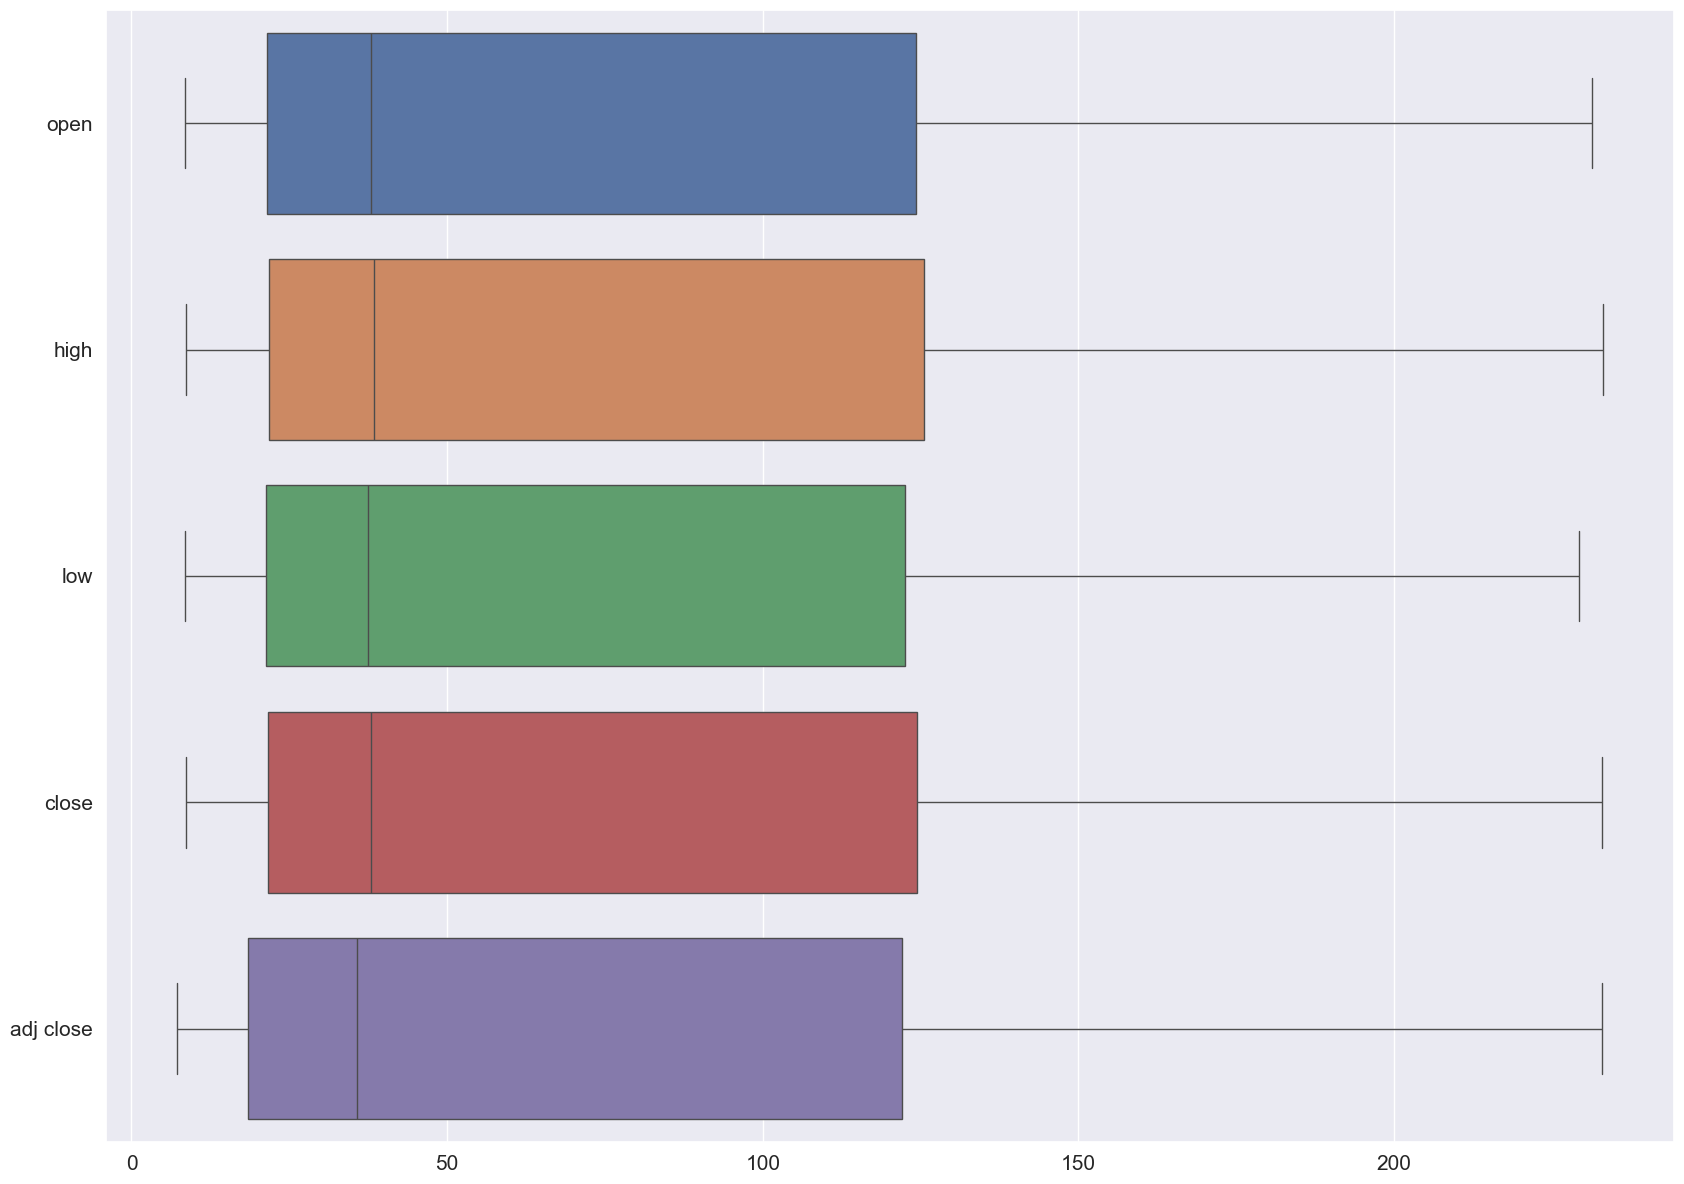

In [9]:
sns.boxplot(df.drop('volume',axis=1),orient='h')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

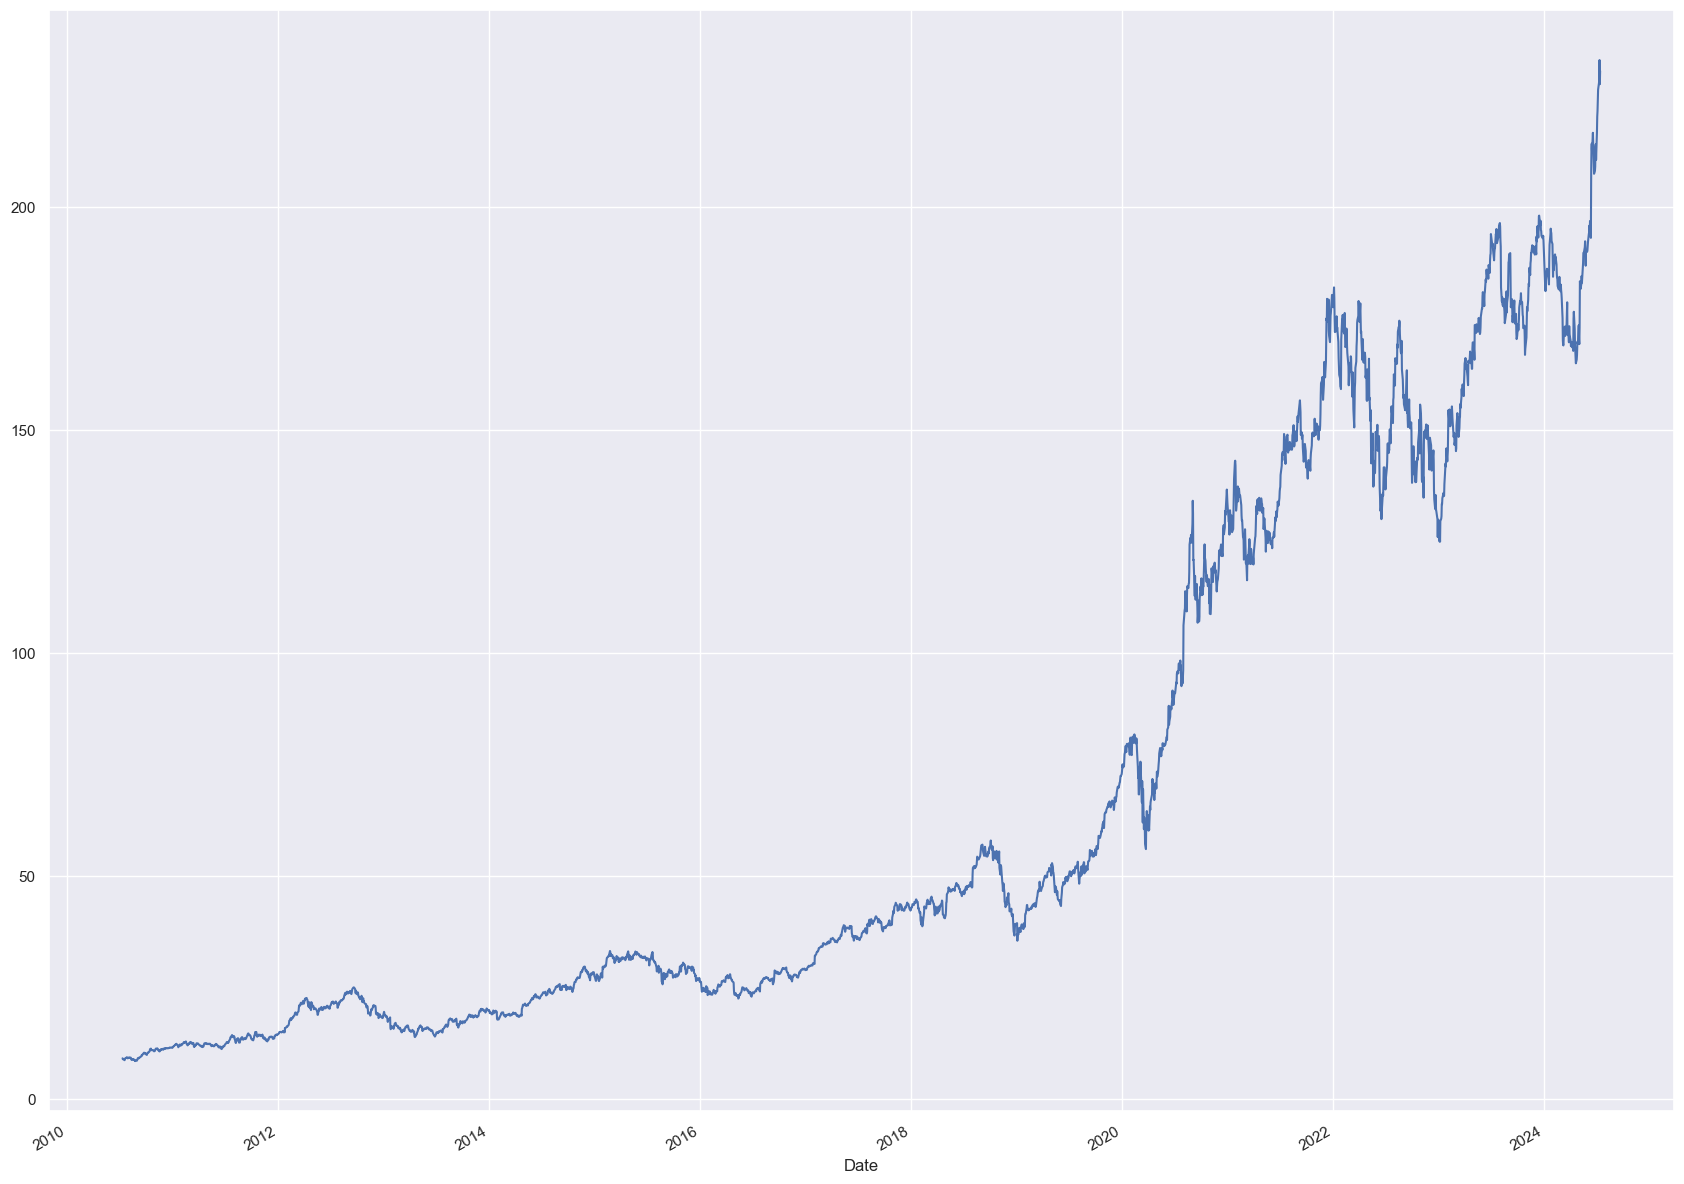

In [10]:
close_df=df['close']
close_df.plot()

plt.show()

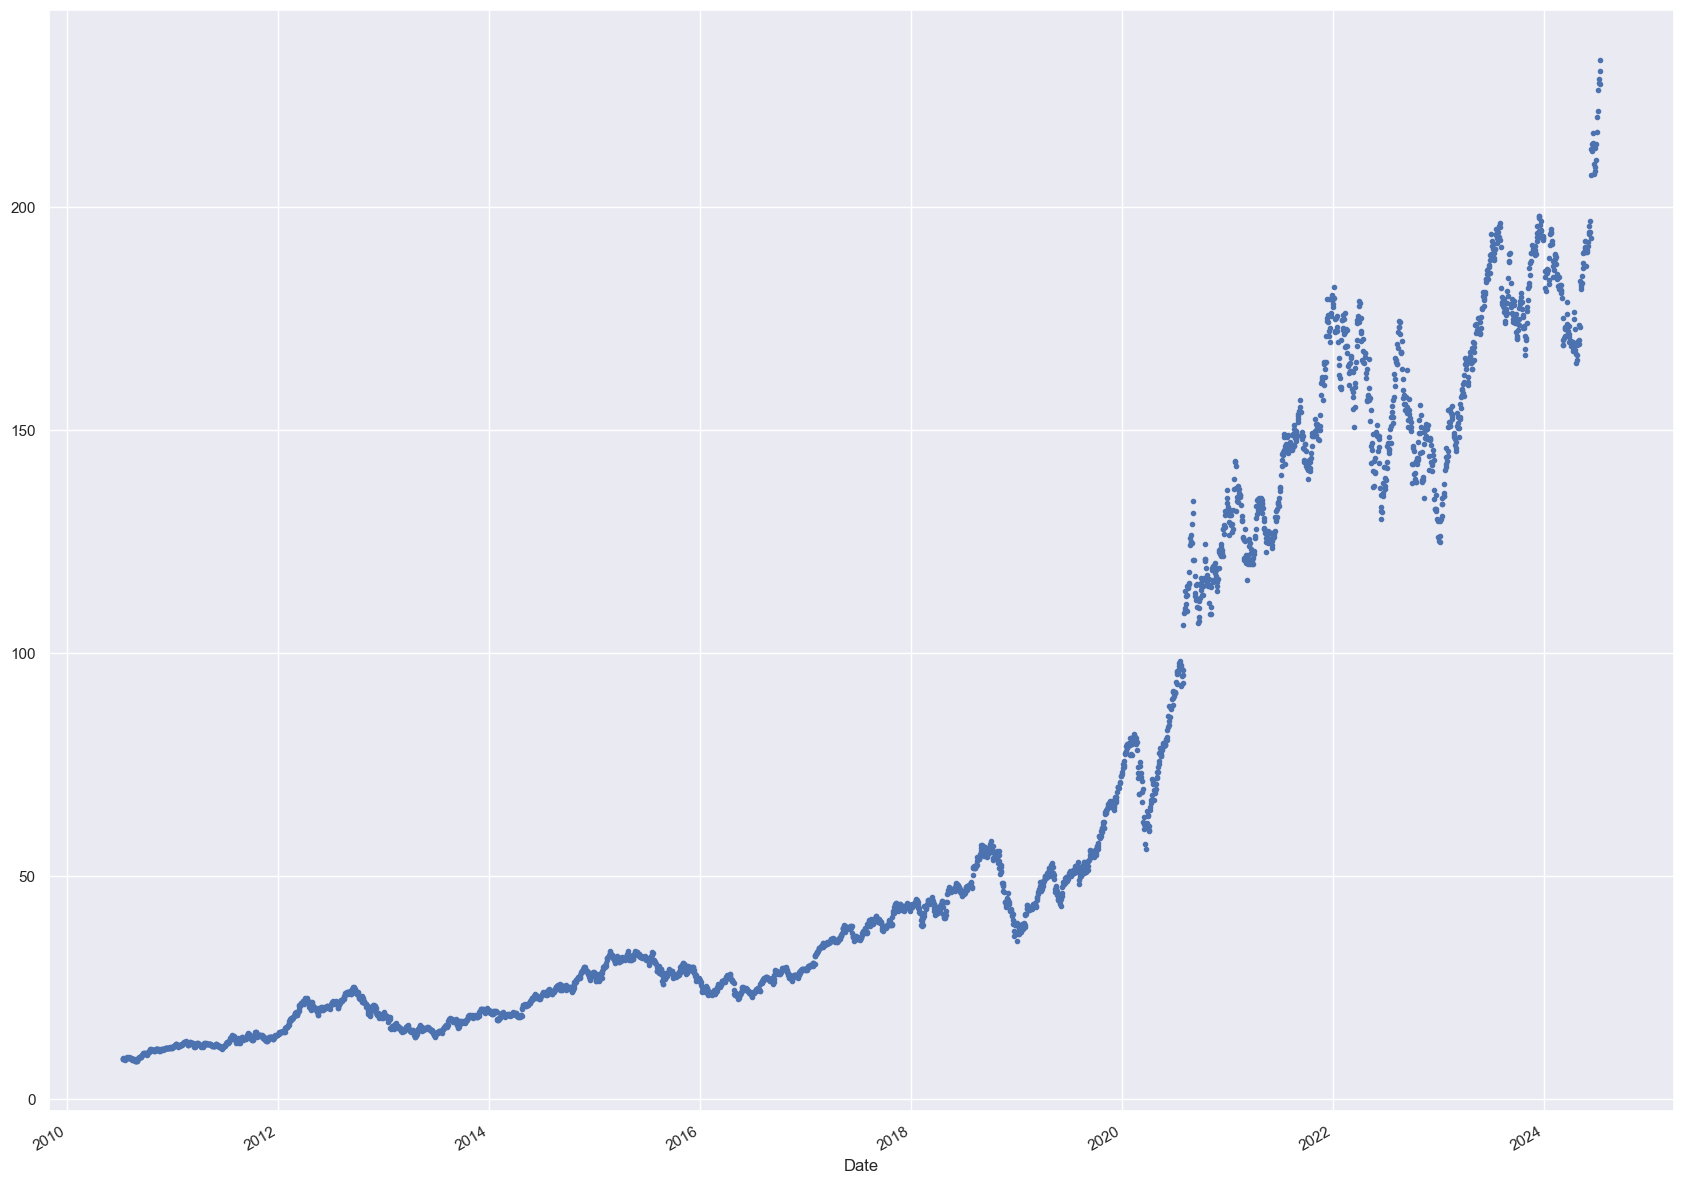

In [11]:
close_df.plot(style='b.')
plt.show()

<Axes: xlabel='Date'>

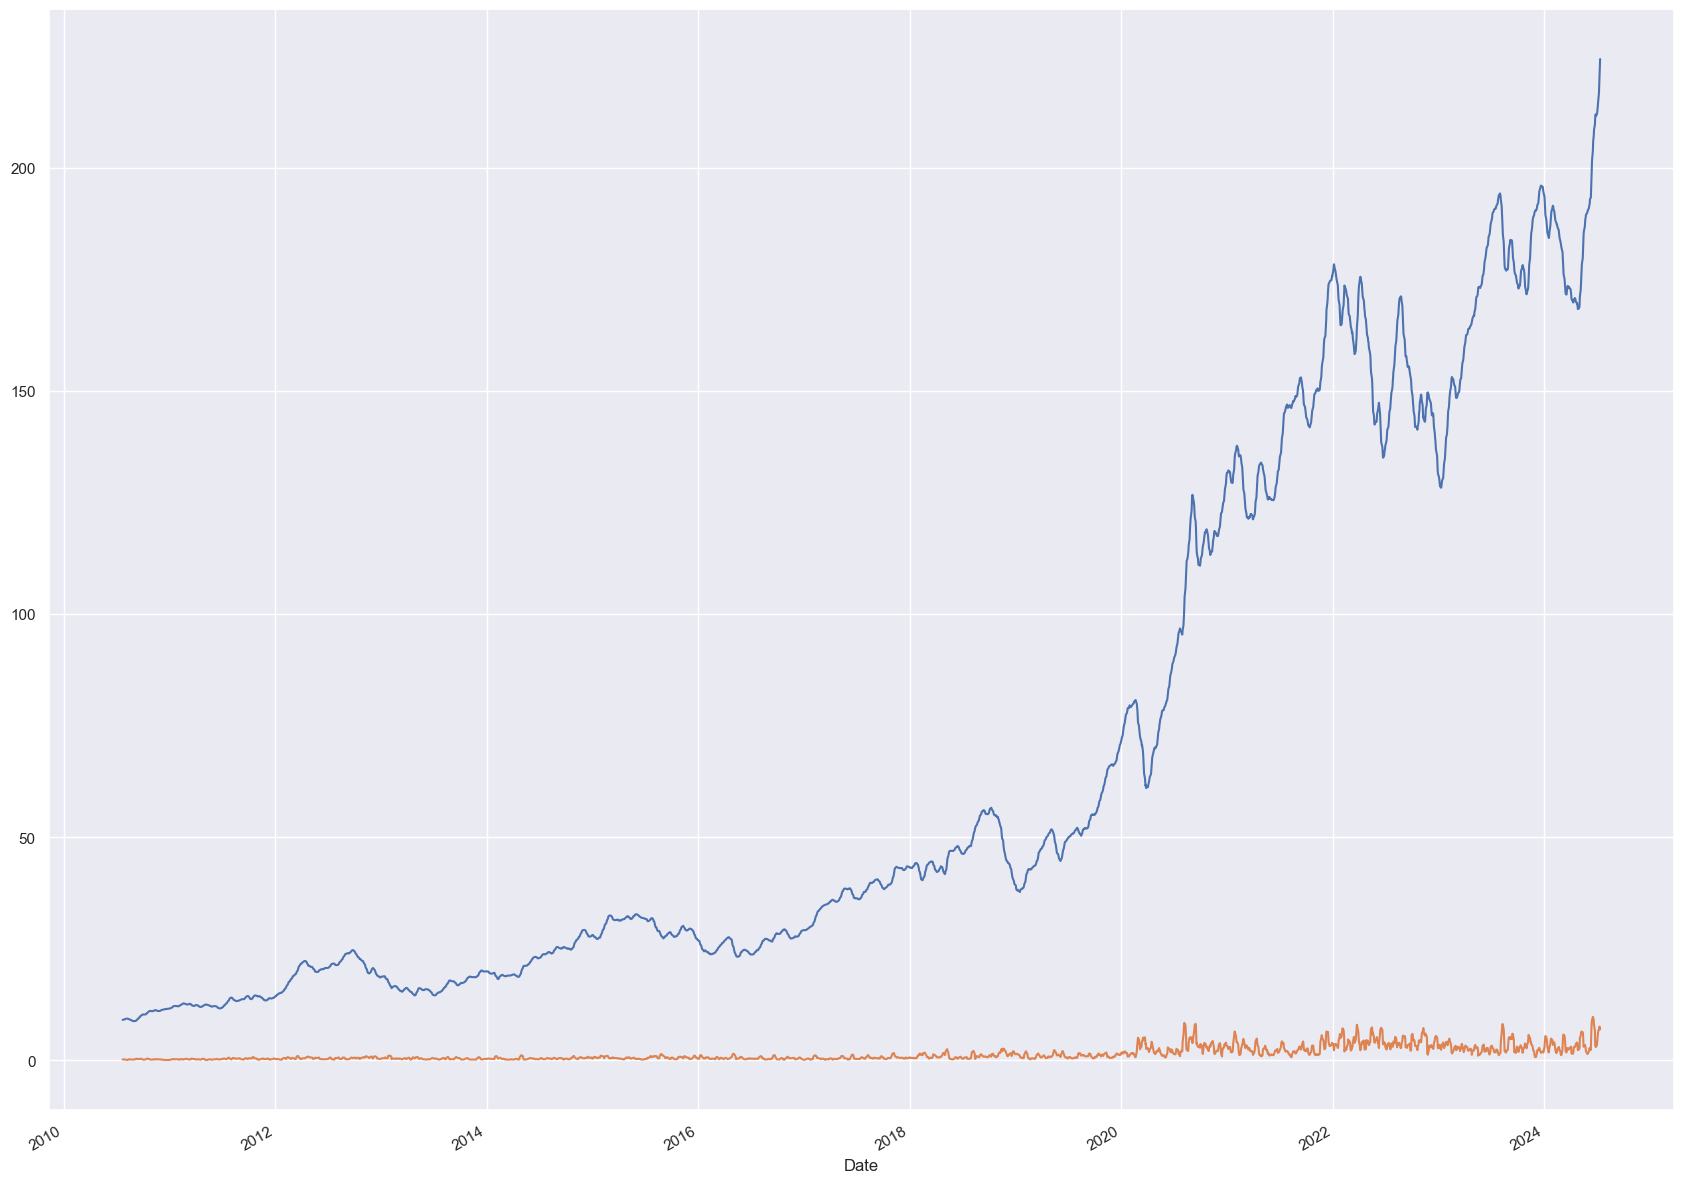

In [12]:
close_df.rolling(10).mean().plot()
close_df.rolling(10).std().plot()

In [13]:
close_df.asfreq('D').isnull().sum()

1590

In [14]:
close_df=close_df.asfreq('D')
close_df.fillna(close_df.bfill(),inplace=True)
close_df

Date
2010-07-12     9.19
2010-07-13     8.99
2010-07-14     9.03
2010-07-15     8.98
2010-07-16     8.93
              ...  
2024-07-08   227.82
2024-07-09   228.68
2024-07-10   232.98
2024-07-11   227.57
2024-07-12   230.54
Freq: D, Name: close, Length: 5115, dtype: float64

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

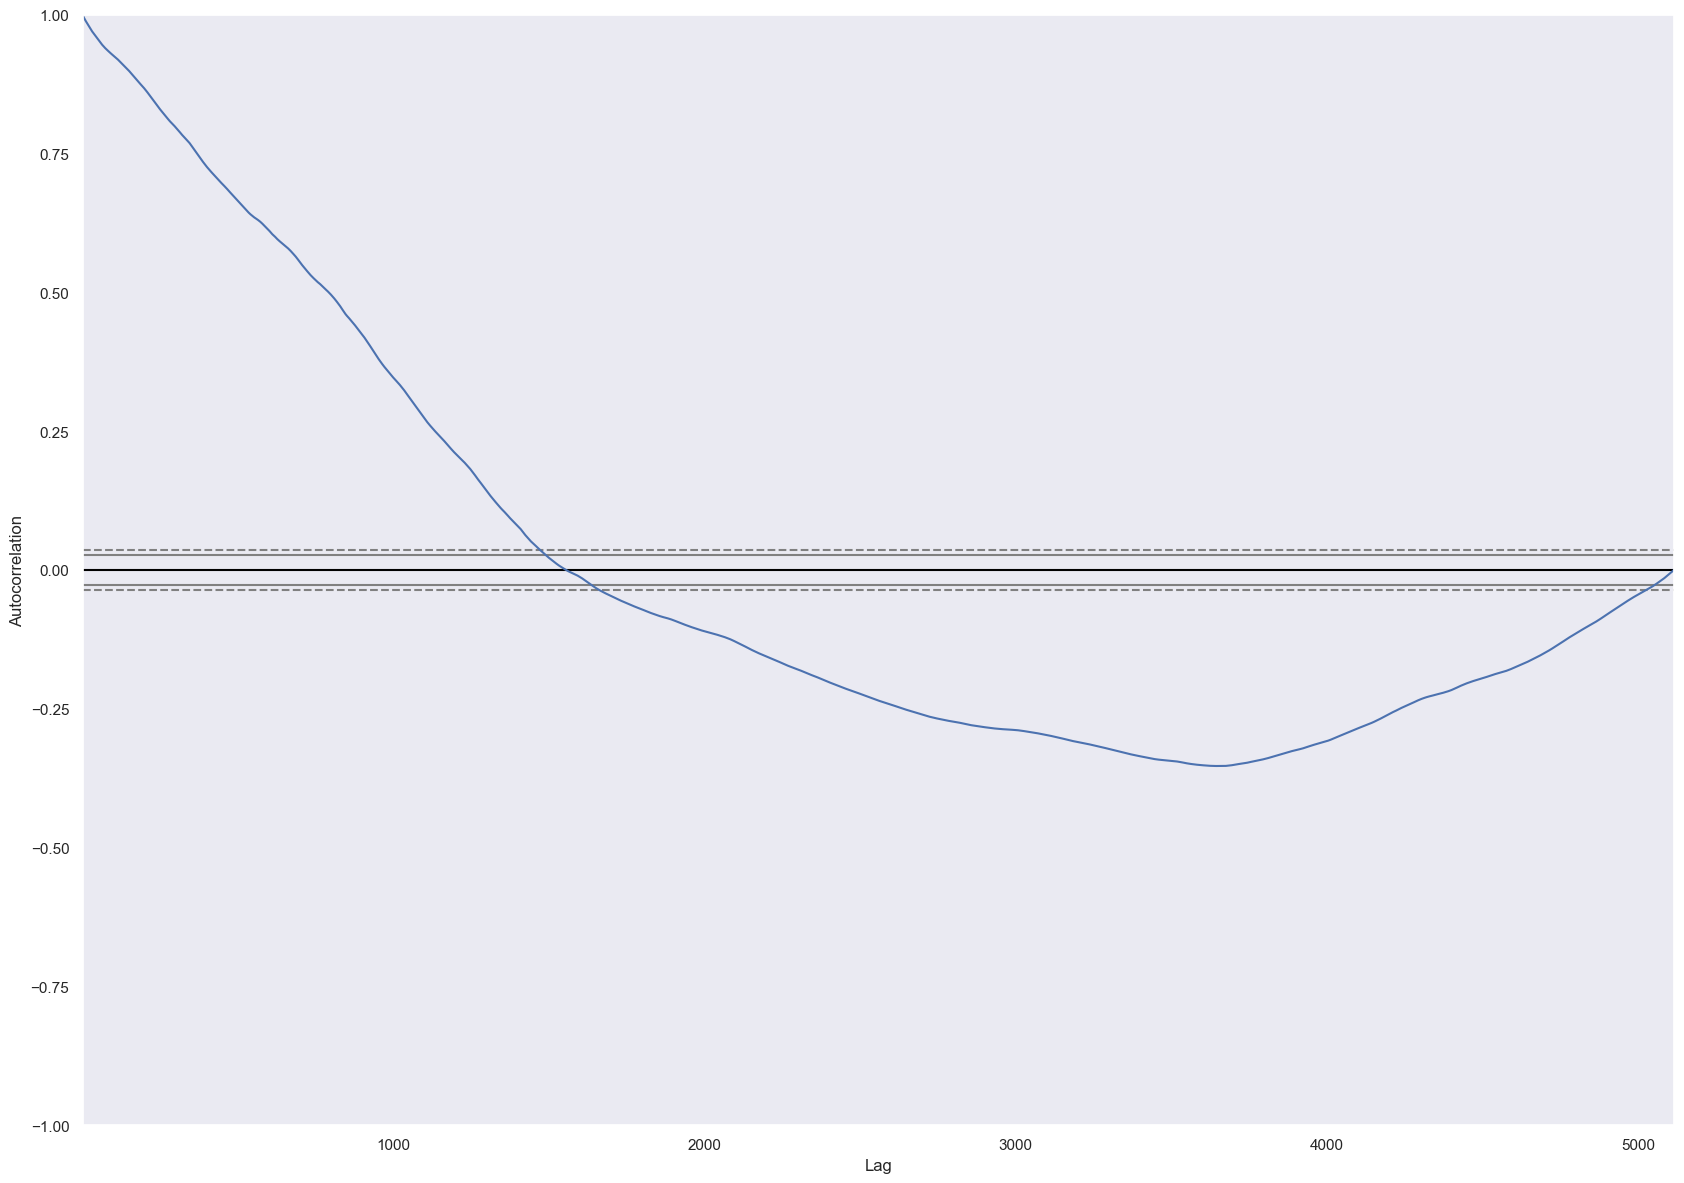

In [15]:
autocorrelation_plot(close_df)

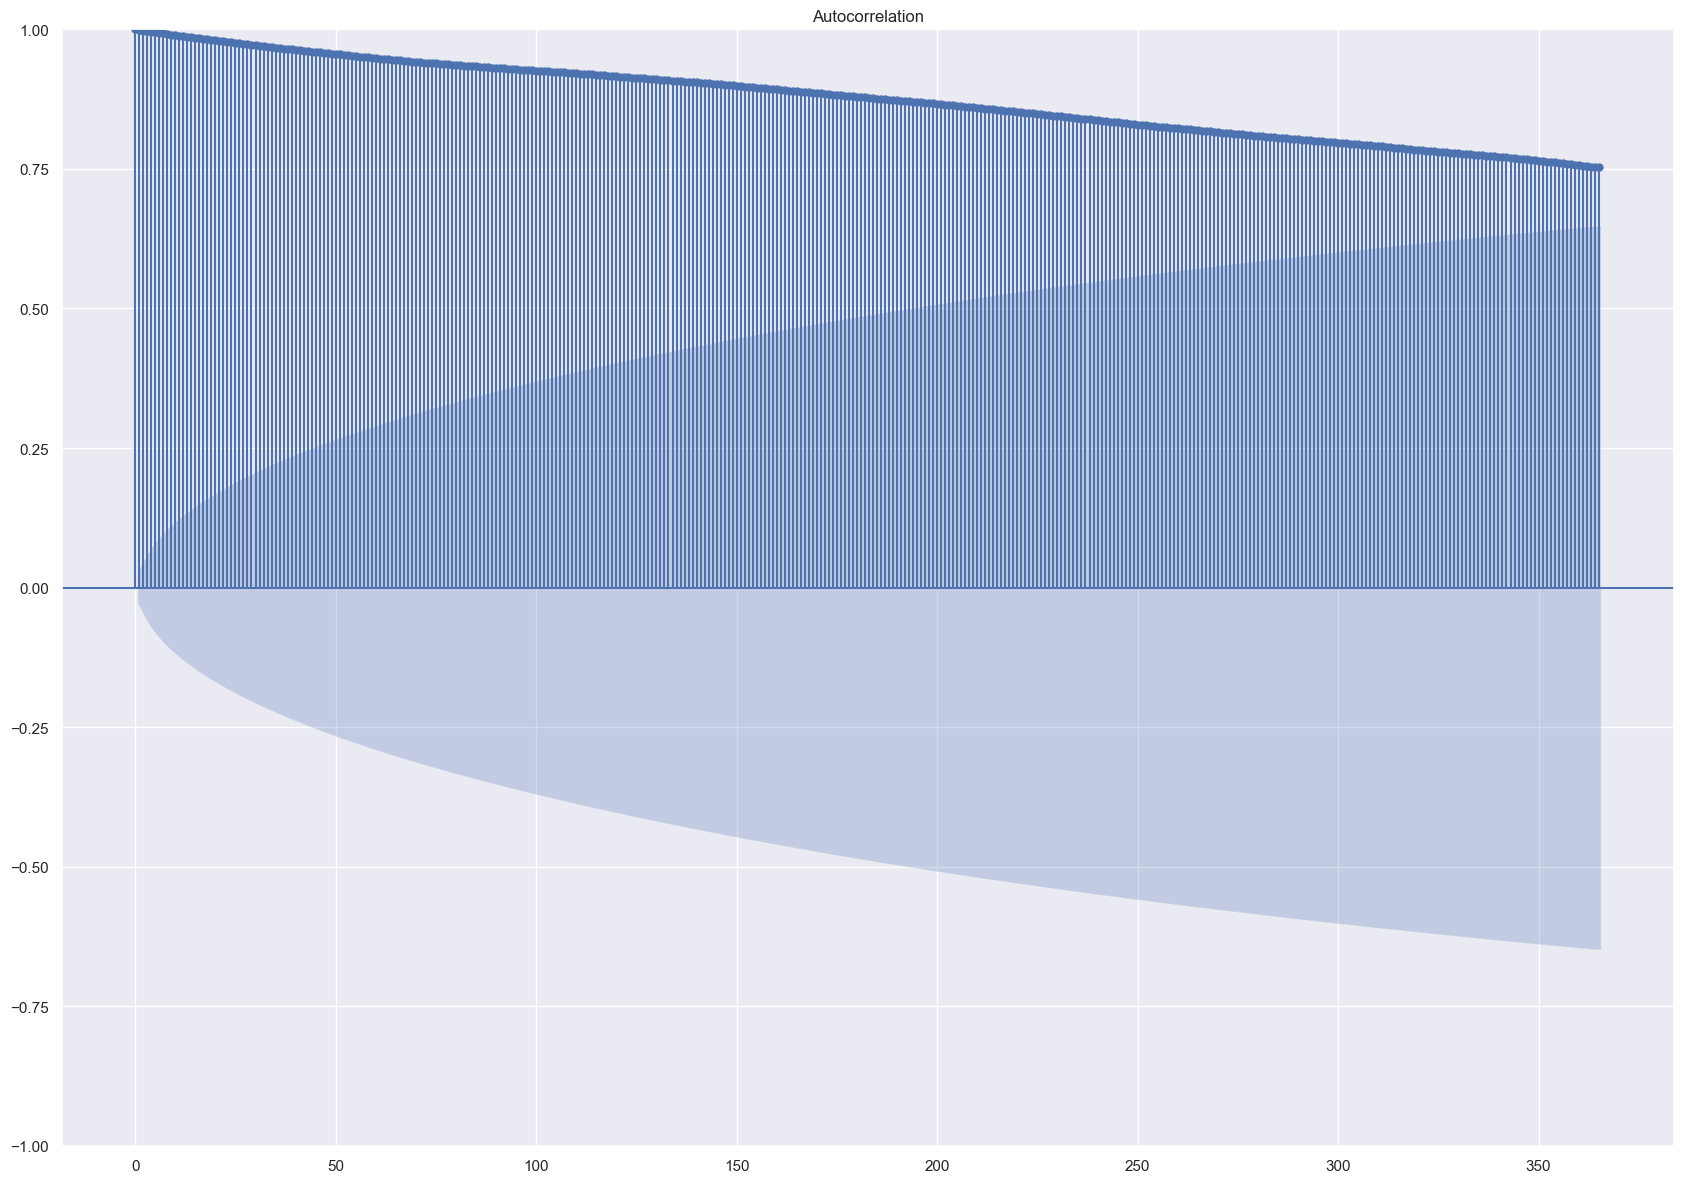

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_plot=plot_acf(close_df,lags=365)

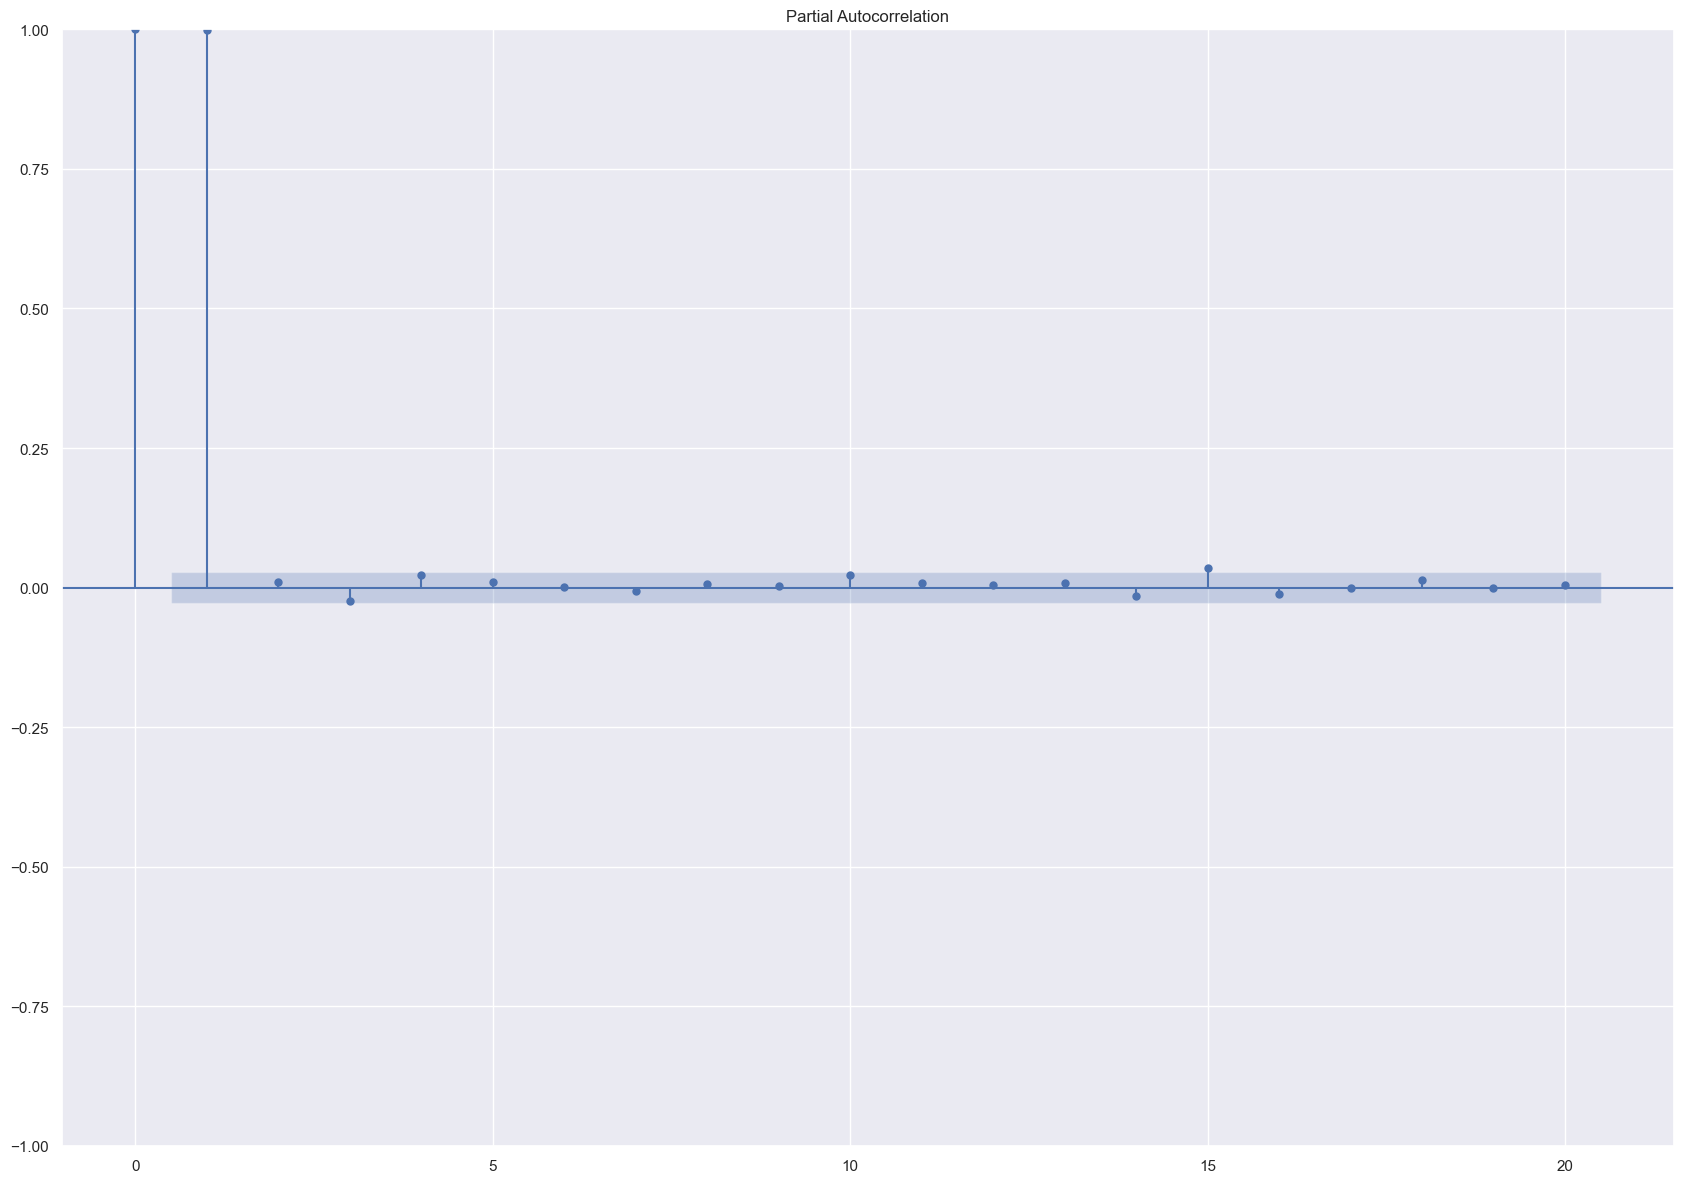

In [17]:
pacf_plot=plot_pacf(close_df,lags=20)

<Axes: xlabel='Date'>

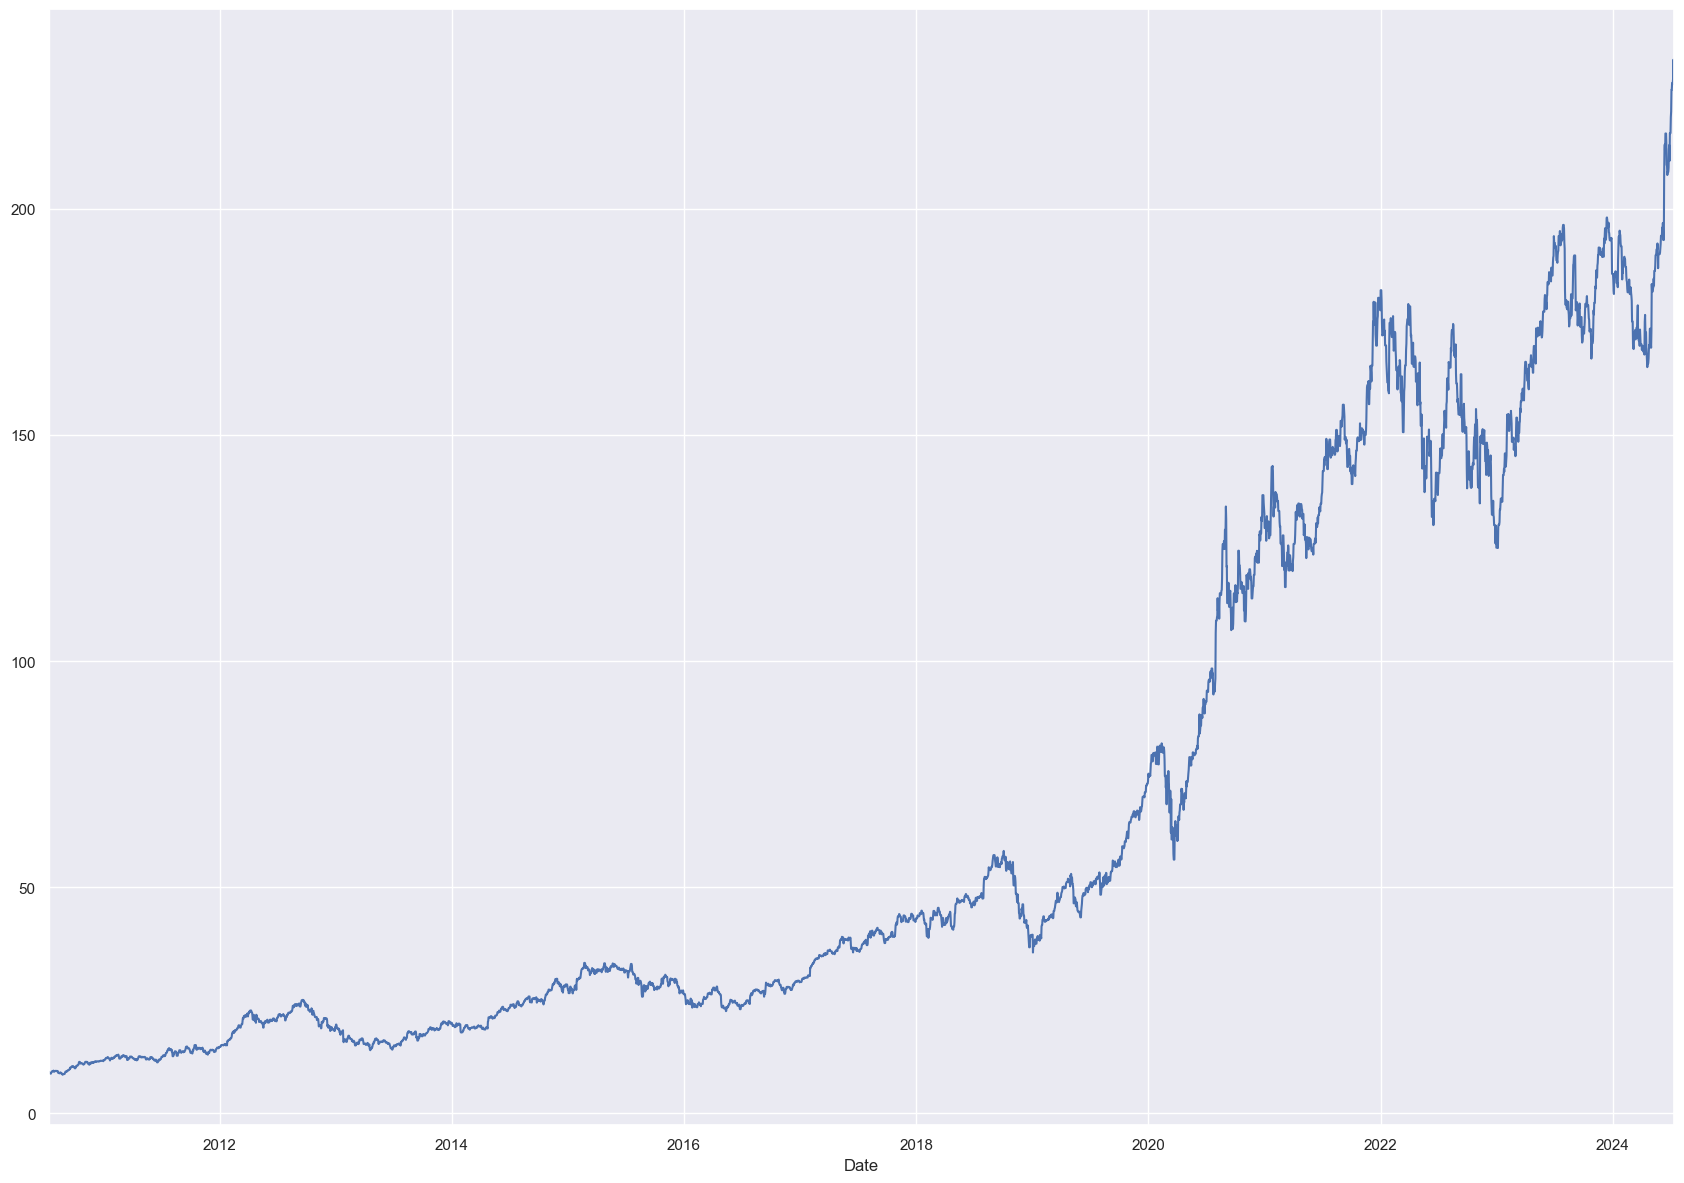

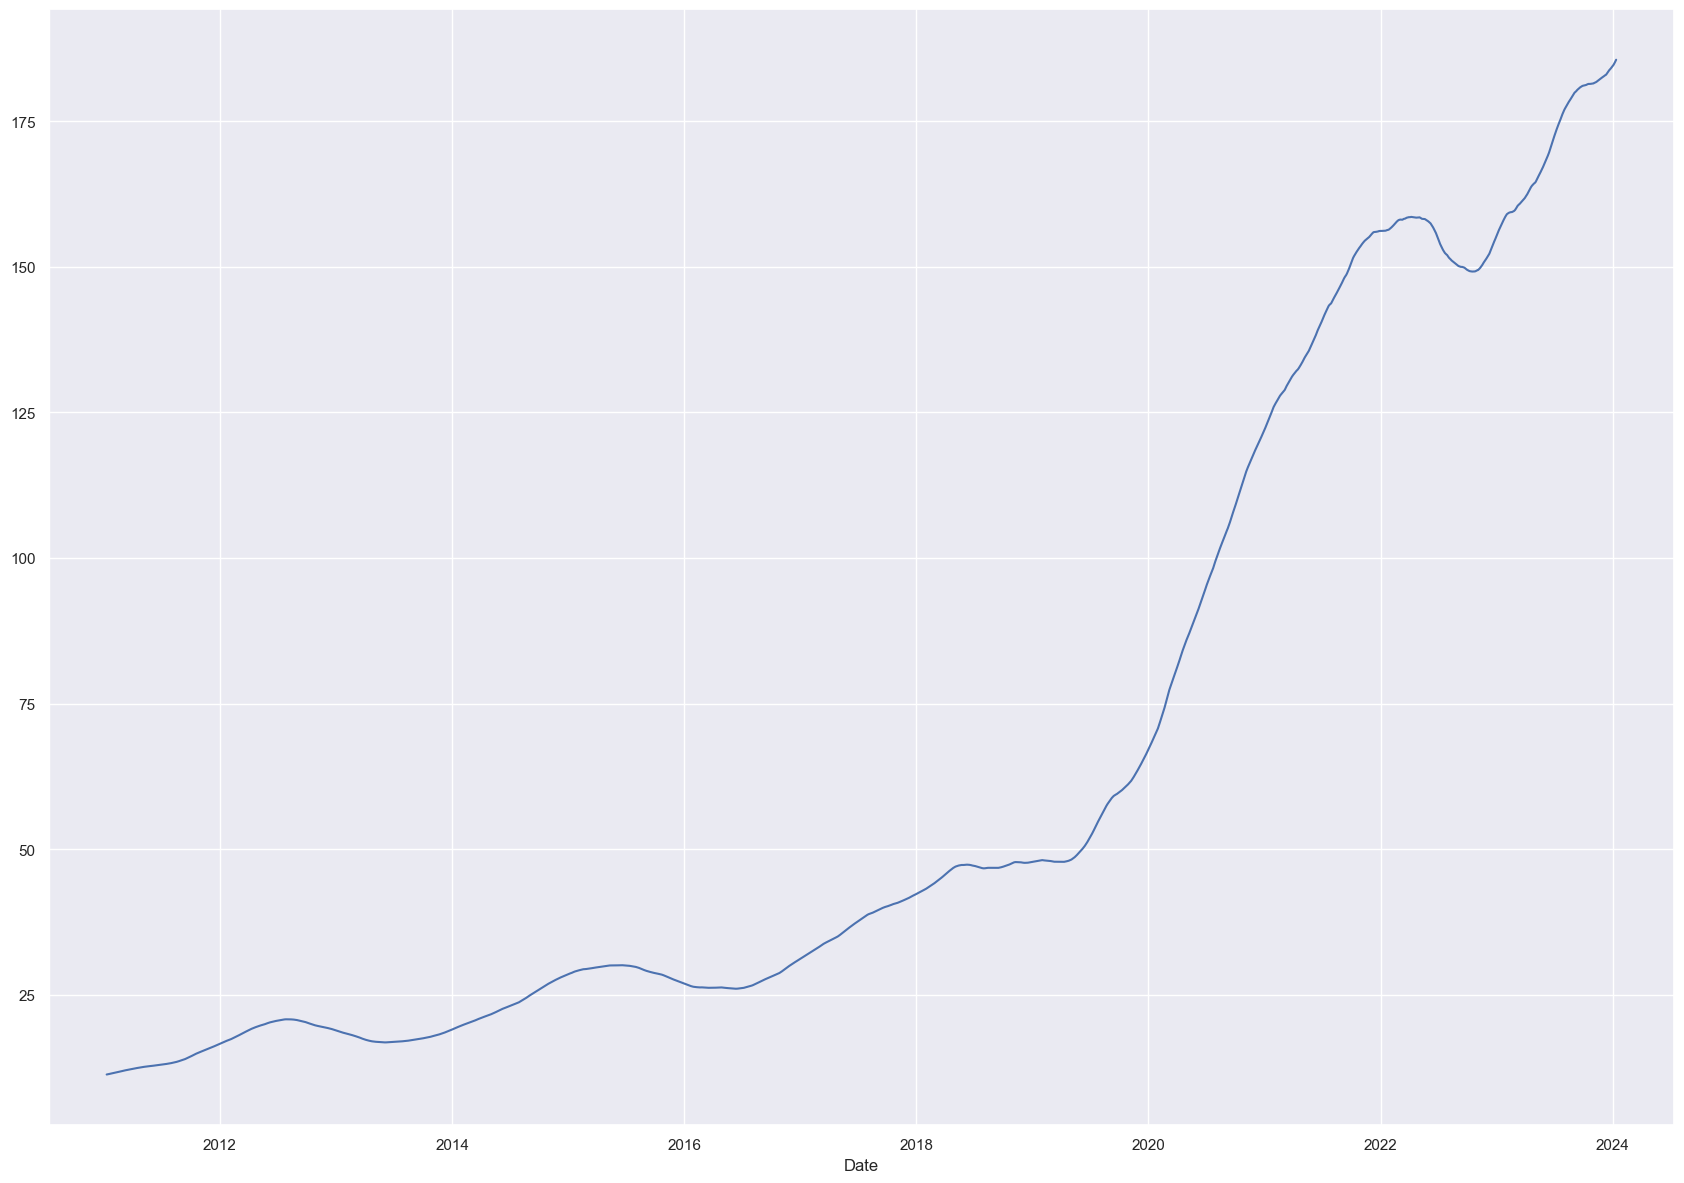

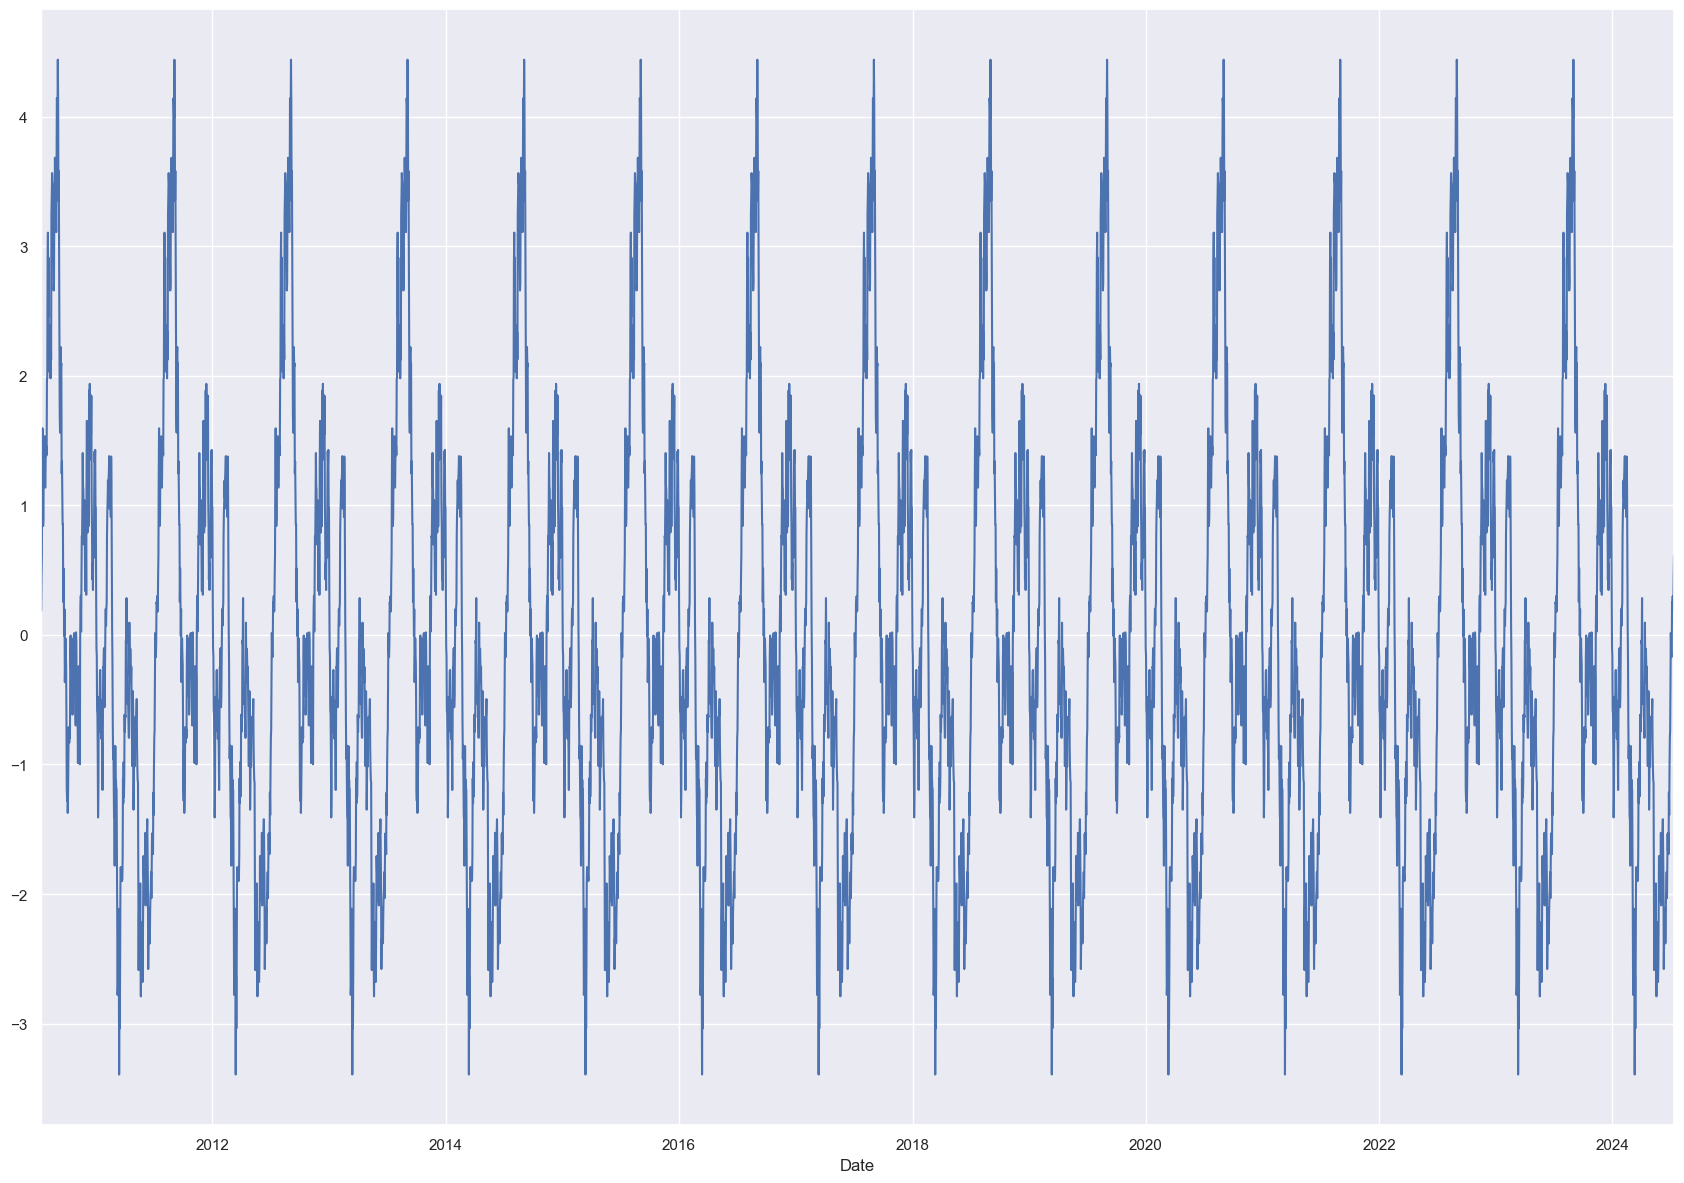

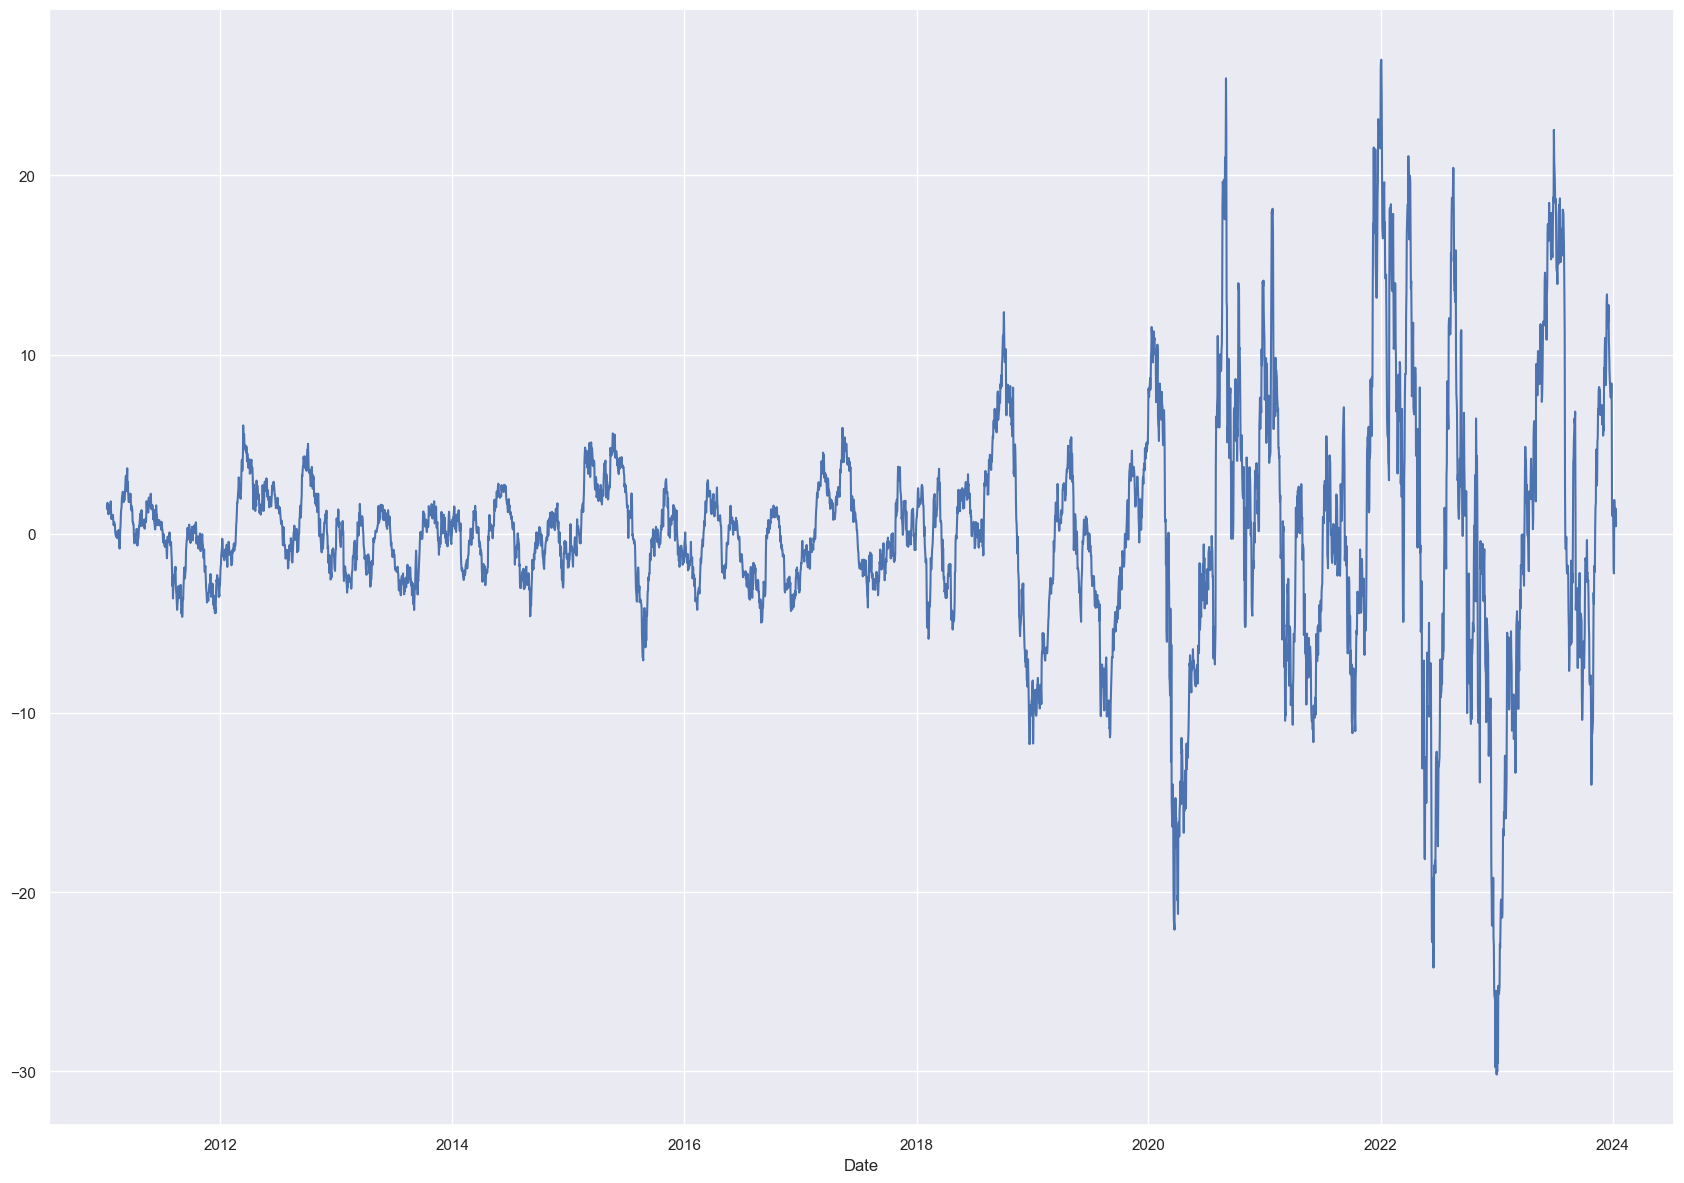

In [18]:
decompose=seasonal_decompose(close_df,period=365)
trend=decompose.trend
seasonal=decompose.seasonal 
residual=decompose.resid

close_df.plot()
plt.figure()
trend.plot()
plt.figure()
seasonal.plot()
plt.figure()
residual.plot()

In [19]:

def adfuller_test(series, signif=0.05):
    """
    Perform the Augmented Dickey-Fuller test on a given time series data.

    Parameters:
    series (pd.Series): The time series data.
    signif (float): Significance level for the test. Default is 0.05.

    Returns:
    None: Prints the test result.
    """
    result = adfuller(series.dropna())
    p_value = result[1]
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value

    print(out.to_string())
    
    if p_value <= signif:
        print(f"\nThe series is likely stationary (p-value: {p_value})")
    else:
        print(f"\nThe series is likely non-stationary (p-value: {p_value})")

adfuller_test(close_df)

Augmented Dickey-Fuller Test:
ADF Statistic             1.23
p-value                   1.00
# Lags Used              33.00
# Observations Used    5081.00
Critical Value (1%)      -3.43
Critical Value (5%)      -2.86
Critical Value (10%)     -2.57

The series is likely non-stationary (p-value: 0.9961755098286443)


In [20]:
close_df.autocorr(lag=1)

0.9997585750523729

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

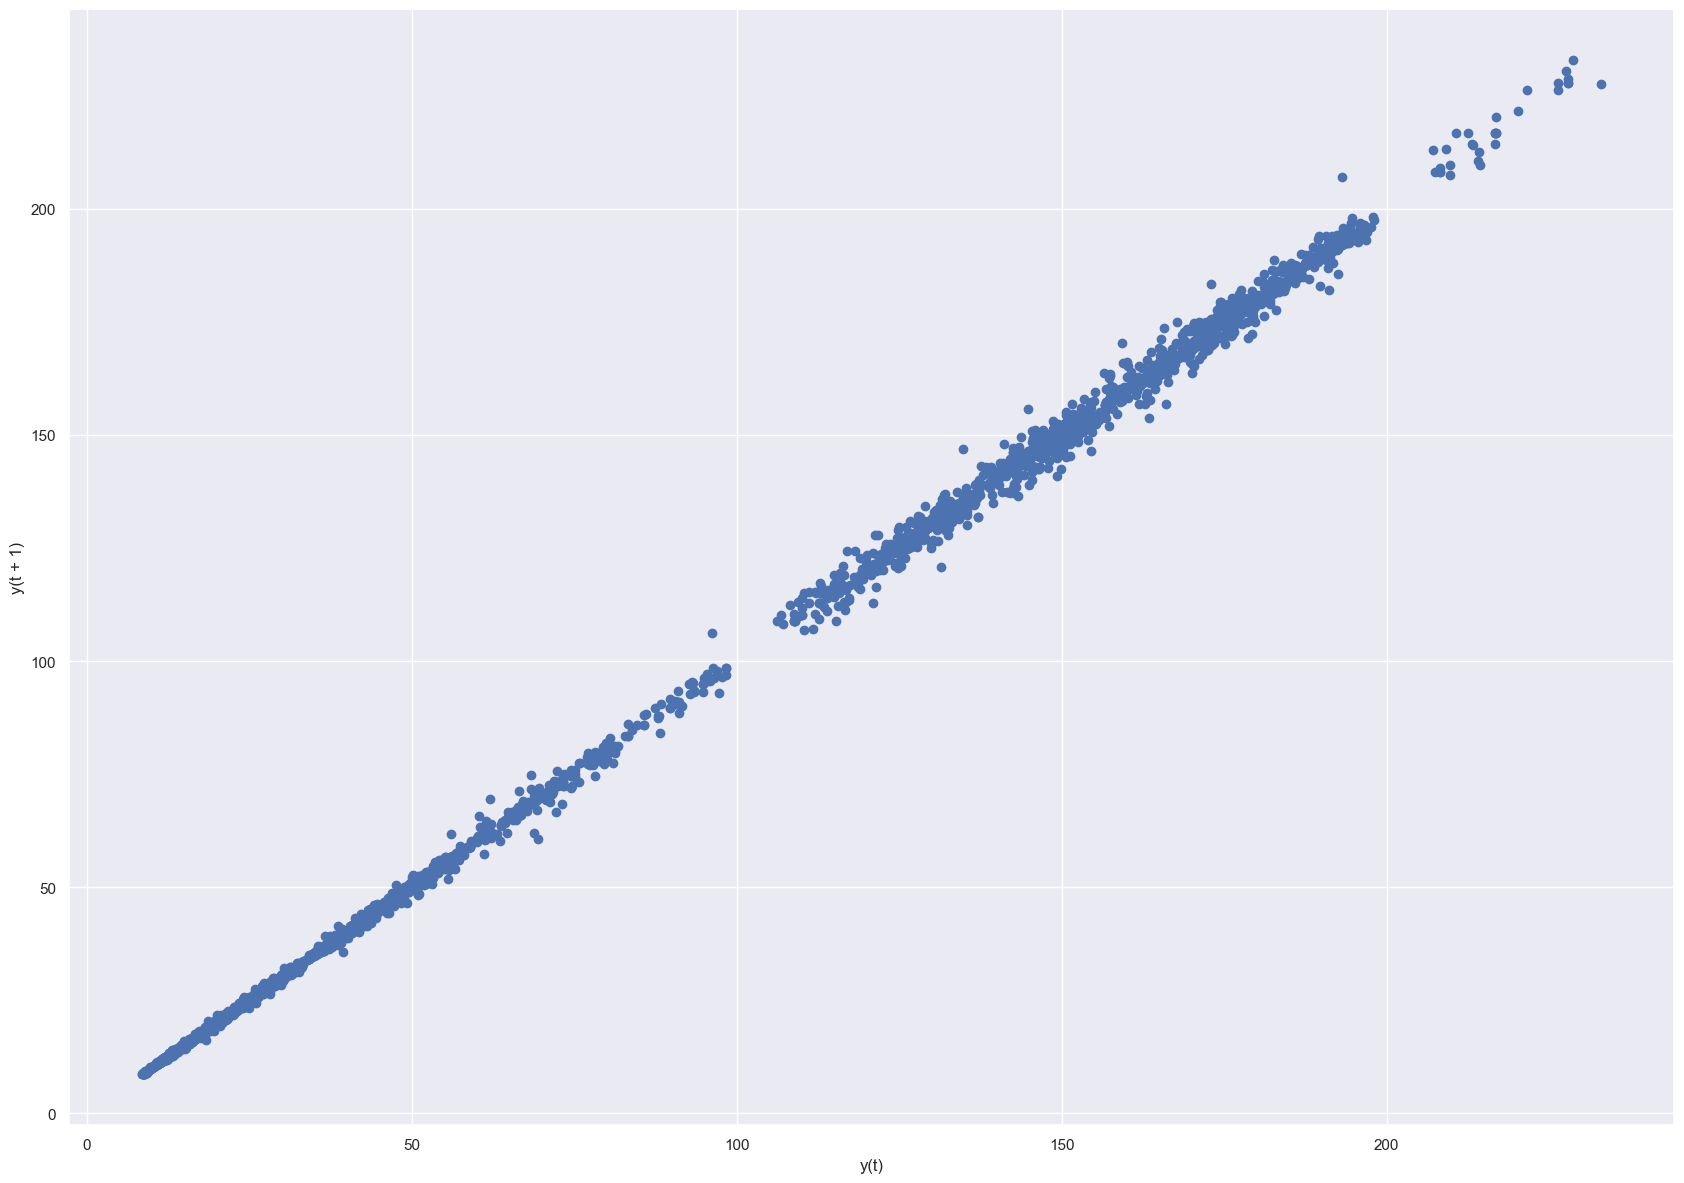

In [21]:
lag_plot(close_df,lag=1)

In [22]:
train_df=close_df[:-366]
test_df=close_df[-366:]
test_df

Date
2023-07-13   190.54
2023-07-14   190.69
2023-07-15   193.99
2023-07-16   193.99
2023-07-17   193.99
              ...  
2024-07-08   227.82
2024-07-09   228.68
2024-07-10   232.98
2024-07-11   227.57
2024-07-12   230.54
Freq: D, Name: close, Length: 366, dtype: float64

In [23]:

model_auto_arima=auto_arima(train_df,trace=True)
model_auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15350.964, Time=4.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15355.818, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15356.688, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15356.678, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15358.441, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15354.651, Time=1.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15354.585, Time=1.95 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=15341.180, Time=5.86 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15350.736, Time=1.81 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=15342.447, Time=3.92 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=15339.070, Time=6.94 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=15340.868, Time=5.27 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=15344.756, Time=4.86 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=15323.313, Time=7.87 sec
 ARIMA(2,1,4)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4749
Model:               SARIMAX(3, 1, 4)   Log Likelihood               -7652.657
Date:                Wed, 17 Jul 2024   AIC                          15323.313
Time:                        05:15:35   BIC                          15381.503
Sample:                    07-12-2010   HQIC                         15343.761
                         - 07-12-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0823      0.037      2.227      0.026       0.010       0.155
ar.L1         -0.1721      0.024     -7.083      0.000      -0.220      -0.124
ar.L2         -0.1408      0.027     -5.177      0.000      -0.194      -0.088
ar.L3         -0.8447      0.025    -33.142      0.000      -0.895      -0.795
ma.L1          0.1587      0.025      6.346      0.000       0.110       0.208
ma.L2          0.1319      0.028      4.735      0.000       0.077       0.186
ma.L3          0.8400      0.027     31.105      0.000       0.787       0.893
ma.L4         -0.0628      0.008     -8.285      0.000      -0.078      -0.048
sigma2         1.4704      0.010    142.822      0.000       1.450       1.491
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             59368.96
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              68.12   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
%%time

arima_model=ARIMA(train_df,order=(3,1,4)).fit() 
arima_model.summary()


CPU times: total: 6.31 s
Wall time: 4.56 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 4749
Model:                 ARIMA(3, 1, 4)   Log Likelihood               -7655.045
Date:                Wed, 17 Jul 2024   AIC                          15326.090
Time:                        05:15:39   BIC                          15377.814
Sample:                    07-12-2010   HQIC                         15344.266
                         - 07-12-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1525      0.017     -8.722      0.000      -0.187      -0.118
ar.L2         -0.1626      0.019     -8.673      0.000      -0.199      -0.126
ar.L3         -0.8868      0.017    -51.906      0.000      -0.920      -0.853
ma.L1          0.1401      0.018      7.627      0.000       0.104       0.176
ma.L2          0.1517      0.019      7.843      0.000       0.114       0.190
ma.L3          0.8851      0.018     49.202      0.000       0.850       0.920
ma.L4         -0.0559      0.007     -7.625      0.000      -0.070      -0.042
sigma2         1.4713      0.010    143.152      0.000       1.451       1.491
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             59599.61
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              69.05   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
predictions=arima_model.predict(start=len(train_df),end=len(train_df)+len(test_df)-1)
predictions

2023-07-13   189.83
2023-07-14   189.68
2023-07-15   189.78
2023-07-16   189.64
2023-07-17   189.78
              ...  
2024-07-08   189.73
2024-07-09   189.73
2024-07-10   189.73
2024-07-11   189.73
2024-07-12   189.73
Freq: D, Name: predicted_mean, Length: 366, dtype: float64

In [26]:

test_df

Date
2023-07-13   190.54
2023-07-14   190.69
2023-07-15   193.99
2023-07-16   193.99
2023-07-17   193.99
              ...  
2024-07-08   227.82
2024-07-09   228.68
2024-07-10   232.98
2024-07-11   227.57
2024-07-12   230.54
Freq: D, Name: close, Length: 366, dtype: float64

In [27]:

mean_absolute_percentage_error(test_df,predictions)

0.05806406470017475

In [28]:
np.sqrt(mean_squared_error(test_df,predictions))/test_df.mean()

0.0740711213721702

<Axes: xlabel='Date'>

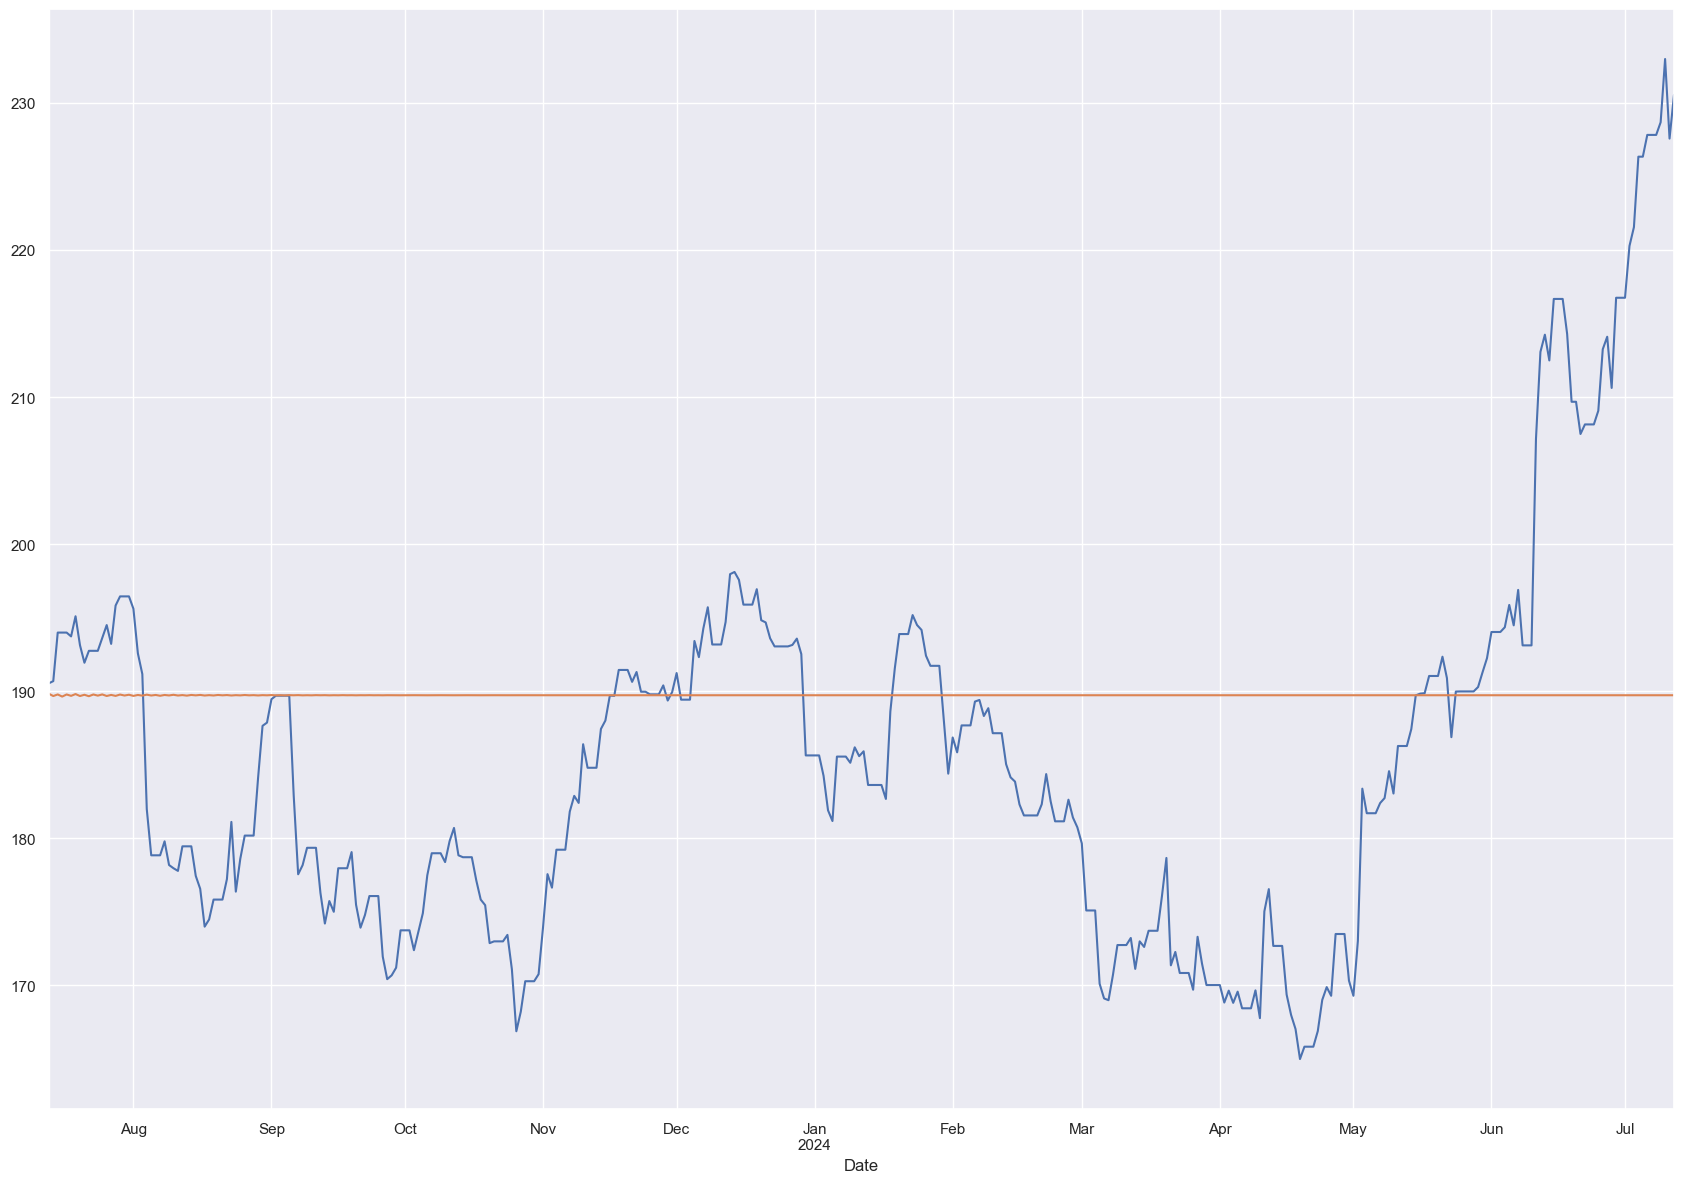

In [29]:
test_df.plot()
predictions.plot()

## Auto Regression 

In [30]:

# number of lags for autoregression is the first point in pacf plot that drops to 0 
auto_reg_model=AutoReg(train_df,lags=1).fit()
auto_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  close   No. Observations:                 4749
Model:                     AutoReg(1)   Log Likelihood               -7675.468
Method:               Conditional MLE   S.D. of innovations              1.219
Date:                Wed, 17 Jul 2024   AIC                          15356.935
Time:                        05:15:41   BIC                          15376.331
Sample:                    07-13-2010   HQIC                         15363.751
                         - 07-12-2023                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0194      0.027      0.731      0.465      -0.033       0.071
close.L1       1.0003      0.000   2904.309      0.000       1.000       1.001
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9997           +0.0000j            0.9997            0.0000
-----------------------------------------------------------------------------
"""

In [31]:
predictions_aut_reg=auto_reg_model.predict(start=len(train_df),end=len(train_df)+len(test_df)-1)
predictions_aut_reg

2023-07-13   189.85
2023-07-14   189.93
2023-07-15   190.01
2023-07-16   190.09
2023-07-17   190.17
              ...  
2024-07-08   220.81
2024-07-09   220.91
2024-07-10   221.00
2024-07-11   221.09
2024-07-12   221.18
Freq: D, Length: 366, dtype: float64

In [32]:
test_df

Date
2023-07-13   190.54
2023-07-14   190.69
2023-07-15   193.99
2023-07-16   193.99
2023-07-17   193.99
              ...  
2024-07-08   227.82
2024-07-09   228.68
2024-07-10   232.98
2024-07-11   227.57
2024-07-12   230.54
Freq: D, Name: close, Length: 366, dtype: float64

In [33]:
mean_absolute_percentage_error(test_df,predictions_aut_reg)

0.11351656484029425

In [34]:
np.sqrt(mean_squared_error(test_df,predictions_aut_reg))/test_df.mean()

0.12771573161106664

<Axes: xlabel='Date'>

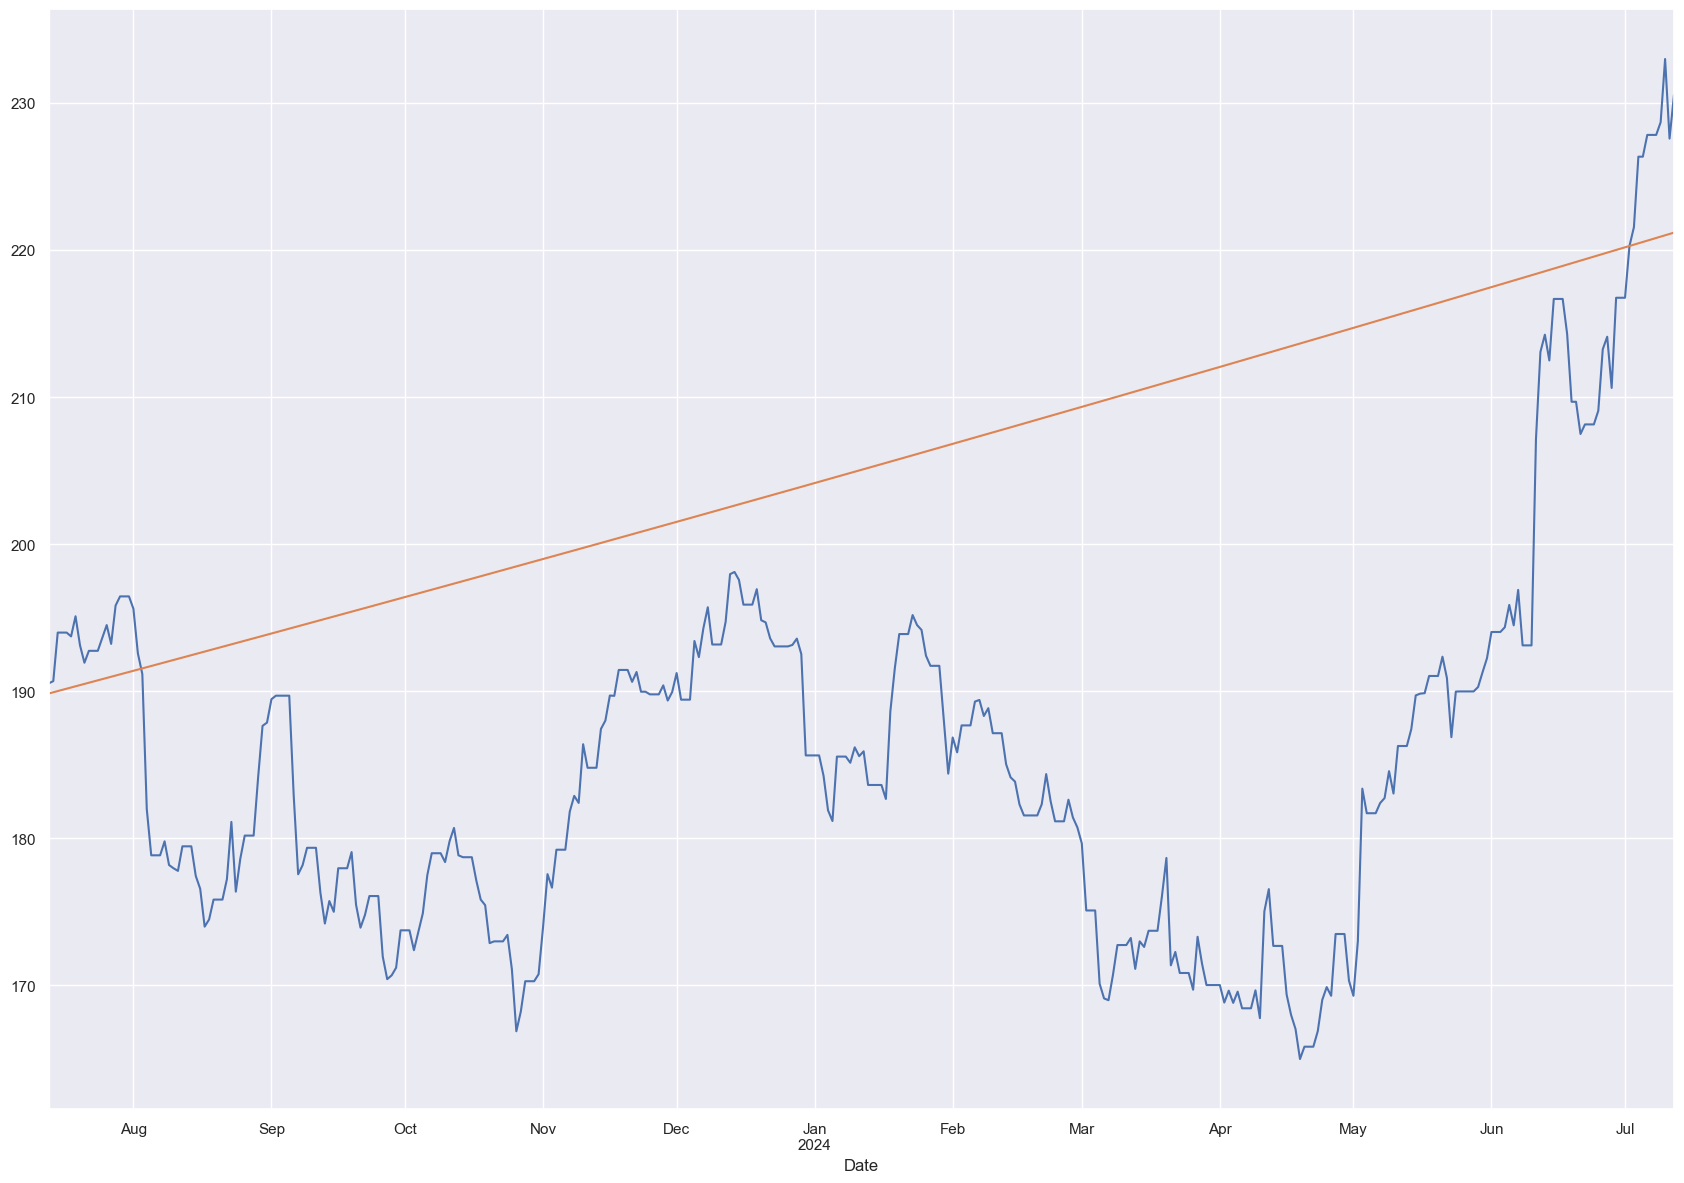

In [35]:
test_df.plot()
predictions_aut_reg.plot()

## LSTM 

In [154]:
train_df

Date
2010-07-12     9.19
2010-07-13     8.99
2010-07-14     9.03
2010-07-15     8.98
2010-07-16     8.93
              ...  
2023-07-08   188.61
2023-07-09   188.61
2023-07-10   188.61
2023-07-11   188.08
2023-07-12   189.77
Freq: D, Name: close, Length: 4749, dtype: float64

In [155]:

scaler=MinMaxScaler() 
scaled_train=scaler.fit_transform(train_df.values.reshape(-1,1))
scaled_train,scaled_train.shape

(array([[0.0033441 ],
        [0.00228655],
        [0.00246569],
        ...,
        [0.9710897 ],
        [0.96823104],
        [0.97734643]]),
 (4749, 1))

In [156]:

n_input=10
lstm_model=Sequential() 
lstm_model.add(LSTM(64,input_shape=(n_input,1)))
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(),loss='mse',metrics=['mse'])

In [157]:
generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=128)

In [39]:

def plot_loss_curves(history):
    """
    Plot the training and validation loss curves.
    
    Parameters:
    - history: A History object (from TensorFlow/Keras) or a dictionary containing 'loss' and 'val_loss' keys.
    """
    if hasattr(history, 'history'):  # Keras History object
        history_dict = history.history
    else:  # Dictionary format
        history_dict = history

    # Extract loss values
    loss = history_dict.get('loss', [])
    val_loss = history_dict.get('val_loss', [])

    # Plot loss curves
    plt.figure(figsize=(12, 6))
    plt.plot(loss, label='Training Loss', color='blue')
    if val_loss:
        plt.plot(val_loss, label='Validation Loss', color='red')
    
    # Add titles and labels
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [158]:
lstm_history=lstm_model.fit(generator,epochs=50)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1217 - mse: 0.1217
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0501 - mse: 0.0501
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - mse: 0.0025
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mse: 0.0013
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mse: 0.0013
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - mse: 0.0012
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mse: 0.0013
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mse: 0.0013
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mse: 0.0017
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - mse: 0.0012
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - mse: 0.0014
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.7527e-04 - mse: 9.7527e-04
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s

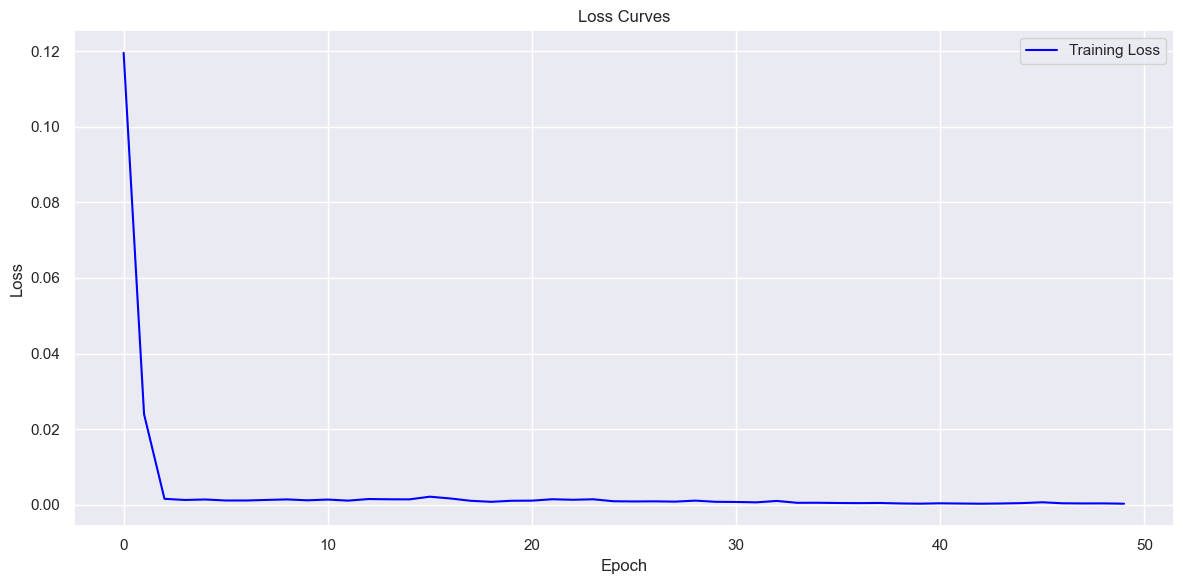

In [159]:
plot_loss_curves(lstm_history)

In [160]:
test_predictions = []
n_features=1

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_df)):
    
    # get the prediction value for the first batch
    current_pred = lstm_model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

In [161]:
test_predictions[0][0]

0.95361584

In [162]:
scaled_predictions=[t[0] for t in test_predictions]
predictions_lstm=scaler.inverse_transform(np.array(scaled_predictions).reshape(-1,1))


In [163]:
predictions_lstm_series=pd.Series(index=test_df.index,data=predictions_lstm.reshape(-1,))
predictions_lstm_series

Date
2023-07-13   185.37
2023-07-14   185.15
2023-07-15   184.96
2023-07-16   184.71
2023-07-17   184.38
              ...  
2024-07-08   180.29
2024-07-09   180.29
2024-07-10   180.29
2024-07-11   180.29
2024-07-12   180.29
Freq: D, Length: 366, dtype: float32

In [164]:
mean_absolute_percentage_error(predictions_lstm_series,test_df)

0.056560137868269404

In [165]:
np.sqrt(mean_squared_error(test_df,predictions_lstm_series))

14.00312450746251

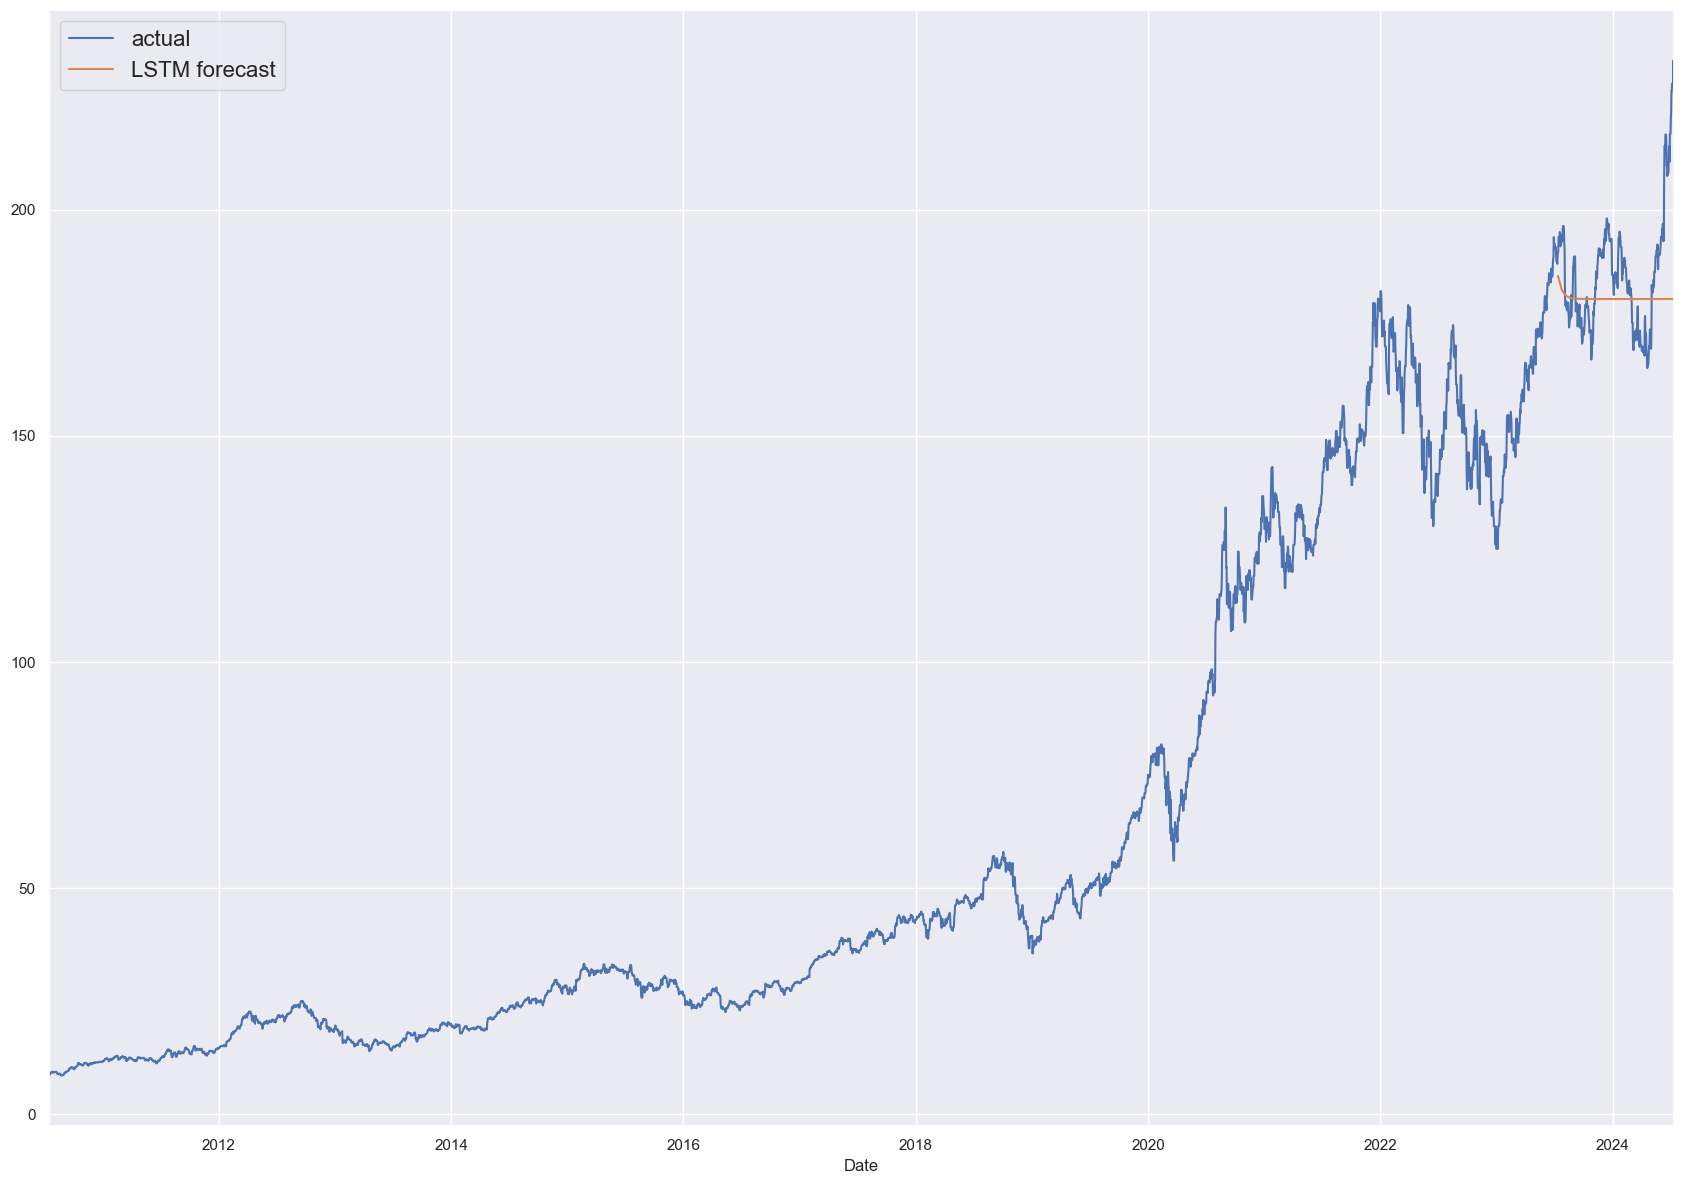

In [172]:
close_df['close'].plot(label='actual') 
predictions_lstm_series.plot(label='LSTM forecast')


plt.legend(loc='upper left',prop={'size':16}) 

plt.show()

<Axes: xlabel='Date'>

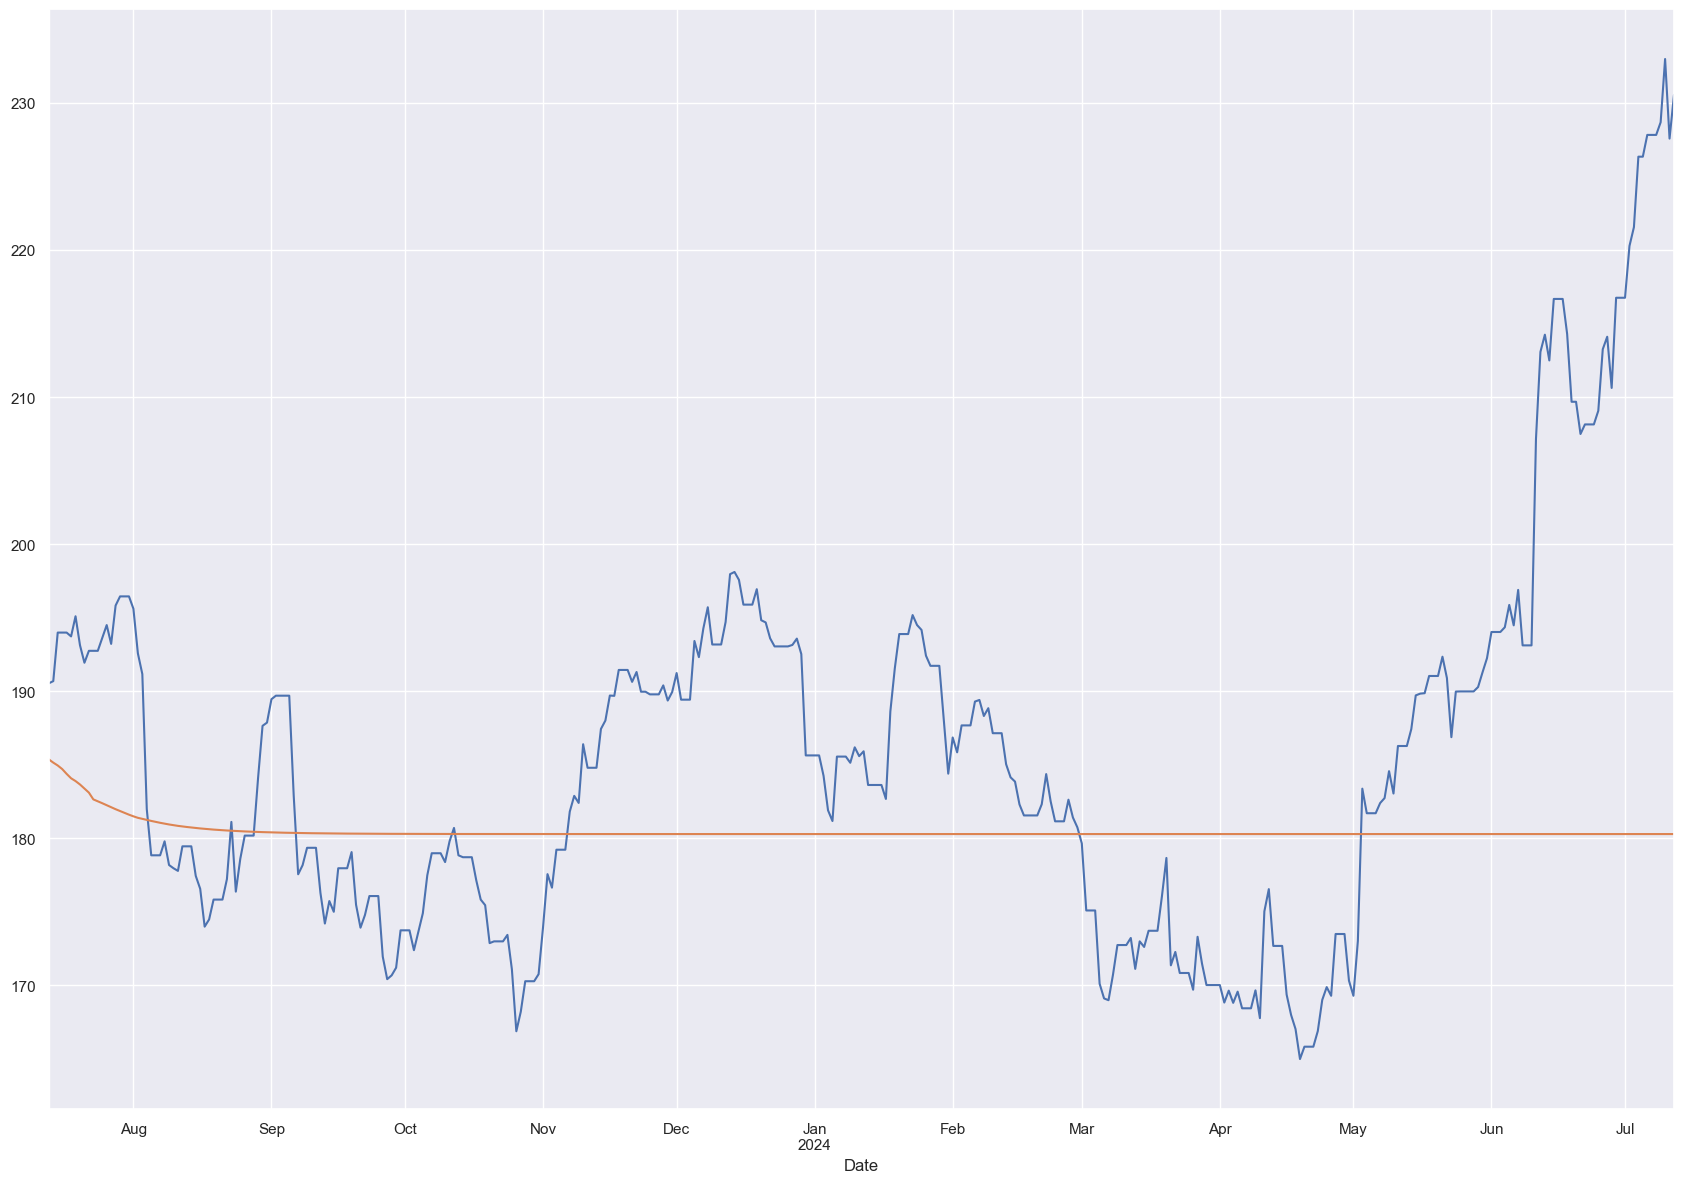

In [171]:
test_df.plot() 
predictions_lstm_series.plot()

### Creating future df with LSTM 

In [185]:
lstm_df=close_df['close']
lstm_df

Date
2010-07-15     8.98
2010-07-16     8.93
2010-07-17     8.77
2010-07-18     8.77
2010-07-19     8.77
              ...  
2024-07-08   227.82
2024-07-09   228.68
2024-07-10   232.98
2024-07-11   227.57
2024-07-12   230.54
Freq: D, Name: close, Length: 5112, dtype: float64

In [186]:

scaler_1=MinMaxScaler() 
scaled_all=scaler_1.fit_transform(lstm_df.values.reshape(-1,1))
scaled_all,scaled_all.shape

(array([[1.83336970e-03],
        [1.58669301e-03],
        [8.99176187e-04],
        ...,
        [1.00000000e+00],
        [9.75892506e-01],
        [9.89127085e-01]]),
 (5112, 1))

In [188]:

n_input=10
lstm_model_2=Sequential() 
lstm_model_2.add(LSTM(64,input_shape=(n_input,1)))
lstm_model_2.add(Dense(1,activation='sigmoid'))
lstm_model_2.compile(optimizer=tf.keras.optimizers.Adam(),loss='mse',metrics=['mse'])

generator_2=TimeseriesGenerator(scaled_all,scaled_all,length=n_input,batch_size=128)

lstm_model_2_history=lstm_model_2.fit(generator_2,epochs=20)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1131 - mse: 0.1131
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0455 - mse: 0.0455
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - mse: 0.0021
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.8201e-04 - mse: 9.8201e-04
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3539e-04 - mse: 7.3539e-04
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mse: 0.0015    
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - mse: 0.0011     
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.9803e-04 - mse: 8.9803e-04
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - mse: 0.0029
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4539e-04 - mse: 9.4539e-04
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - mse: 0.0013   
Epoch 12/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - mse: 0.0011
Epoch

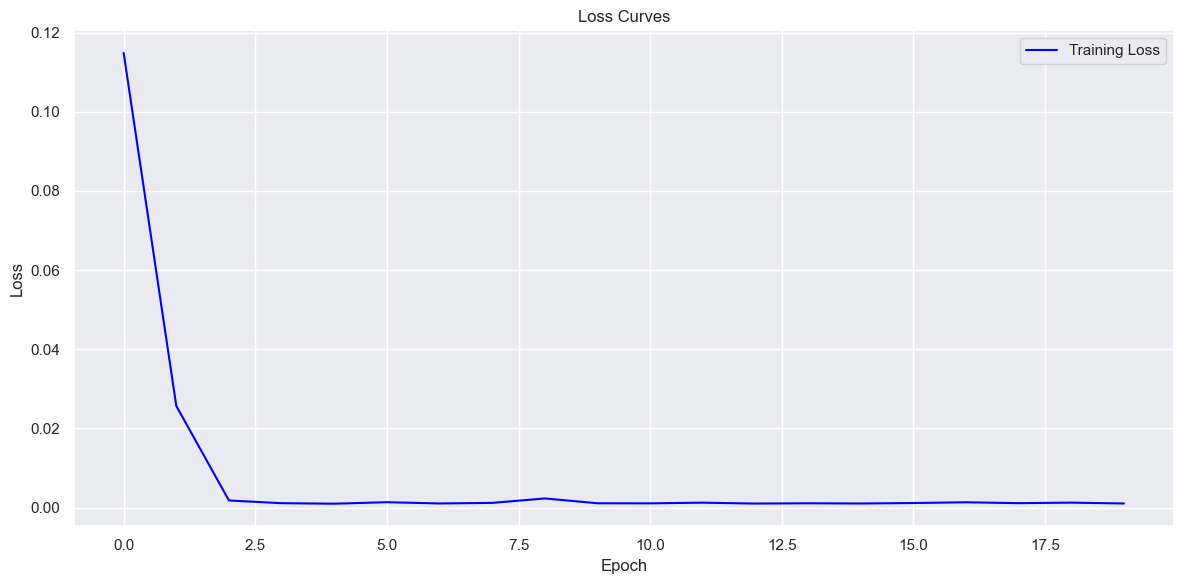

In [189]:
plot_loss_curves(lstm_model_2_history)

In [191]:
test_predictions_2 = []
n_features=1

first_eval_batch = scaled_all[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(1098):
    
    # get the prediction value for the first batch
    current_pred = lstm_model_2.predict(current_batch,verbose=0)[0]
    
    # append the prediction into the array
    test_predictions_2.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

array([0.7663356], dtype=float32)

In [195]:
scaled_predictions_2=[t[0] for t in test_predictions_2]
predictions_lstm_2=scaler_1.inverse_transform(np.array(scaled_predictions_2).reshape(-1,1))

In [197]:
predictions_lstm_2[50:100]

array([[163.50685],
       [163.43082],
       [163.359  ],
       [163.2913 ],
       [163.2276 ],
       [163.16763],
       [163.11116],
       [163.05789],
       [163.00764],
       [162.96019],
       [162.91536],
       [162.87305],
       [162.8331 ],
       [162.79543],
       [162.7599 ],
       [162.72638],
       [162.69473],
       [162.66486],
       [162.63663],
       [162.60995],
       [162.5848 ],
       [162.56102],
       [162.53856],
       [162.51738],
       [162.49736],
       [162.47845],
       [162.4606 ],
       [162.44373],
       [162.42781],
       [162.41275],
       [162.39851],
       [162.38509],
       [162.37239],
       [162.3604 ],
       [162.34908],
       [162.33836],
       [162.32823],
       [162.31868],
       [162.30968],
       [162.30112],
       [162.29306],
       [162.28545],
       [162.27826],
       [162.27144],
       [162.26503],
       [162.25893],
       [162.2532 ],
       [162.24777],
       [162.24263],
       [162.2378 ]],

## MA 

In [50]:
close_df=pd.DataFrame(close_df)

In [51]:
n=150
close_df['SMA'] = close_df['close'].rolling(window=n).mean()


In [52]:
close_df

close    SMA
Date                    
2010-07-12   9.19    NaN
2010-07-13   8.99    NaN
2010-07-14   9.03    NaN
2010-07-15   8.98    NaN
2010-07-16   8.93    NaN
...           ...    ...
2024-07-08 227.82 185.79
2024-07-09 228.68 186.07
2024-07-10 232.98 186.37
2024-07-11 227.57 186.64
2024-07-12 230.54 186.95

[5115 rows x 2 columns]

In [53]:
alpha=.5
close_df['EMA'] =close_df['close'].ewm(alpha=alpha).mean()
close_df

close    SMA    EMA
Date                           
2010-07-12   9.19    NaN   9.19
2010-07-13   8.99    NaN   9.06
2010-07-14   9.03    NaN   9.04
2010-07-15   8.98    NaN   9.01
2010-07-16   8.93    NaN   8.97
...           ...    ...    ...
2024-07-08 227.82 185.79 227.43
2024-07-09 228.68 186.07 228.06
2024-07-10 232.98 186.37 230.52
2024-07-11 227.57 186.64 229.04
2024-07-12 230.54 186.95 229.79

[5115 rows x 3 columns]

In [54]:
len(test_df)

366

In [55]:

k=len(test_df)
forecasted_values_sma = []
for i in range(1, k + 1):
    forecast = close_df['SMA'].iloc[-n:].mean()  # Use mean of last n SMA values
    forecasted_values_sma.append(forecast)

# Forecast next k time points using EMA
forecasted_values_ema = []
for i in range(1, k + 1):
    forecast = close_df['EMA'].iloc[-1]  # Use last EMA value
    forecasted_values_ema.append(forecast)


In [56]:
forecasted_values_sma

[183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.188612950982,
 183.1886129

In [57]:
mean_absolute_percentage_error(test_df,forecasted_values_sma)

0.052202846878978616

In [58]:
mean_absolute_percentage_error(test_df,forecasted_values_ema)

0.24411250479386942

In [59]:
close_df.drop('SMA',axis=1,inplace=True)

In [60]:

close_df['close_1d_before']=close_df['close'].shift(1)
close_df['close_2d_before']=close_df['close'].shift(2)
close_df['close_3d_before']=close_df['close'].shift(3)

close_df.dropna(inplace=True)
close_df

close    EMA  close_1d_before  close_2d_before  close_3d_before
Date                                                                       
2010-07-15   8.98   9.01             9.03             8.99             9.19
2010-07-16   8.93   8.97             8.98             9.03             8.99
2010-07-17   8.77   8.87             8.93             8.98             9.03
2010-07-18   8.77   8.82             8.77             8.93             8.98
2010-07-19   8.77   8.79             8.77             8.77             8.93
...           ...    ...              ...              ...              ...
2024-07-08 227.82 227.43           227.82           227.82           226.34
2024-07-09 228.68 228.06           227.82           227.82           227.82
2024-07-10 232.98 230.52           228.68           227.82           227.82
2024-07-11 227.57 229.04           232.98           228.68           227.82
2024-07-12 230.54 229.79           227.57           232.98           228.68

[5112 rows x 5 columns]

In [61]:
test_df

Date
2023-07-13   190.54
2023-07-14   190.69
2023-07-15   193.99
2023-07-16   193.99
2023-07-17   193.99
              ...  
2024-07-08   227.82
2024-07-09   228.68
2024-07-10   232.98
2024-07-11   227.57
2024-07-12   230.54
Freq: D, Name: close, Length: 366, dtype: float64

In [62]:

X=close_df.drop(columns=['close','EMA'])
y=close_df['close']
X_train=X[:-366]
X_test=X[-366:]
y_train=y[:-366]
y_test=y[-366:]

In [63]:
y_test

Date
2023-07-13   190.54
2023-07-14   190.69
2023-07-15   193.99
2023-07-16   193.99
2023-07-17   193.99
              ...  
2024-07-08   227.82
2024-07-09   228.68
2024-07-10   232.98
2024-07-11   227.57
2024-07-12   230.54
Freq: D, Name: close, Length: 366, dtype: float64

## MLPRegressor

<Axes: xlabel='Date'>

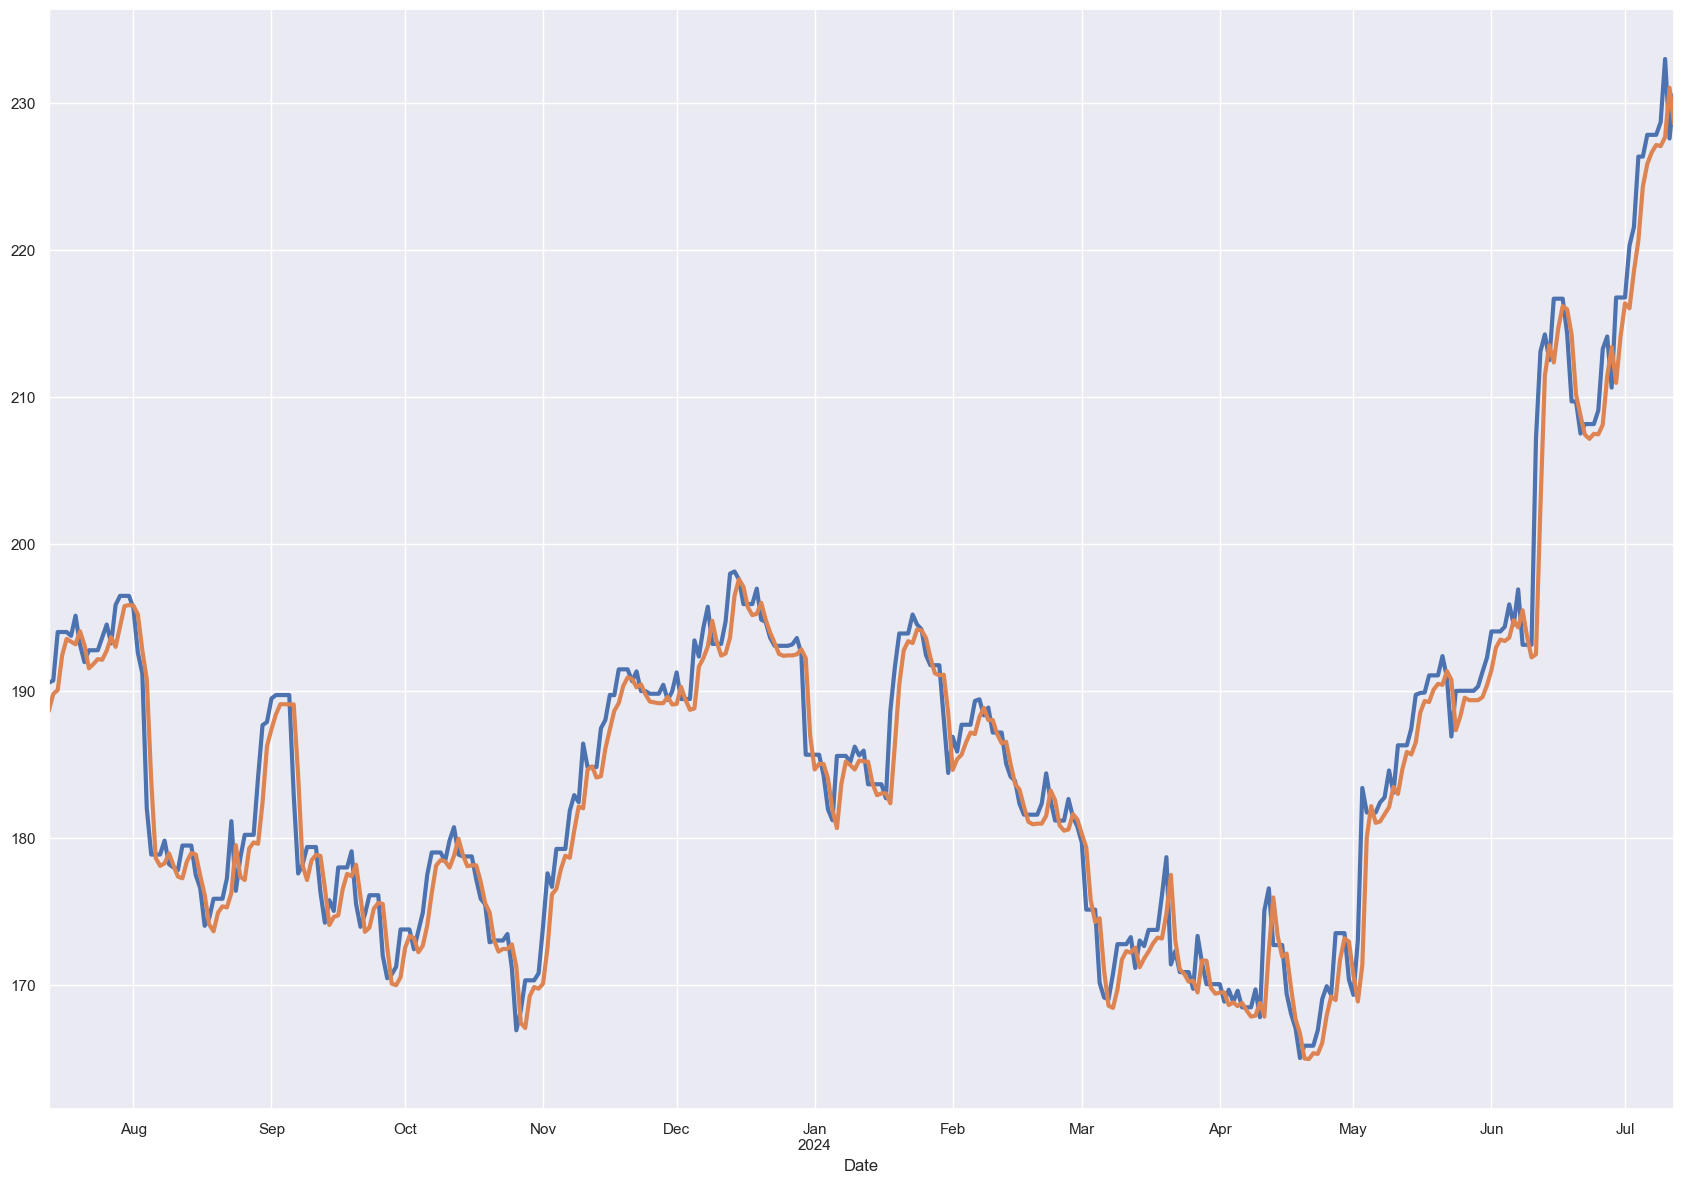

In [176]:
mlp_regressor=MLPRegressor() 
mlp_regressor.fit(X_train,y_train)
mlp_predictions=mlp_regressor.predict(X_test)

mlp_predictions_df=pd.Series(index=pd.date_range(start='2023-07-13',end='2024-07-12'),data=mlp_predictions)
mean_absolute_percentage_error(test_df,mlp_predictions_df)
test_df.plot(lw=3) 
mlp_predictions_df.plot(lw=3)

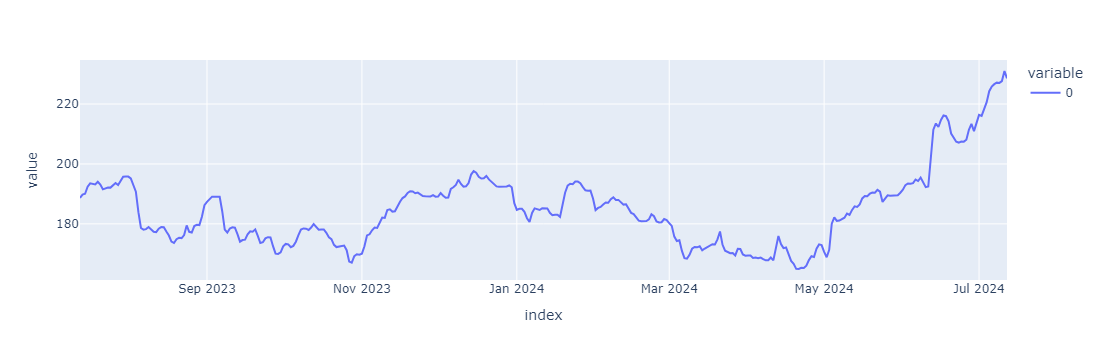

In [183]:
import plotly.express as px 

fig=px.line(mlp_predictions_df)

fig.show() 

In [65]:
mean_absolute_percentage_error(test_df,mlp_predictions_df)


0.007735645212543291

## RandomForestRegressor

In [66]:
forest_reg=RandomForestRegressor() 
forest_reg.fit(X_train,y_train)
forest_predictions=forest_reg.predict(X_test)

forest_predictions_df=pd.Series(index=pd.date_range(start='2023-07-13',end='2024-07-12'),data=forest_predictions)
mean_absolute_percentage_error(test_df,forest_predictions_df)


0.019032818879621157

## LinearRegression

In [67]:
linear_reg=LinearRegression() 
linear_reg.fit(X_train,y_train)
linear_reg_predictions=linear_reg.predict(X_test)

linear_reg_predictions_df=pd.Series(index=pd.date_range(start='2023-07-13',end='2024-07-12'),data=linear_reg_predictions)
mean_absolute_percentage_error(test_df,linear_reg_predictions_df)

0.007245465061420765

## All Regression Algorithms 

In [68]:


def test_regressors(X_train, y_train, X_test, y_test, test_start_date, test_end_date):
    # List of regressors
    regressors = {
        'LinearRegression': LinearRegression(),
        'DecisionTreeRegressor': DecisionTreeRegressor(),
        'KNeighborsRegressor': KNeighborsRegressor(),
        'RandomForestRegressor': RandomForestRegressor(),
        'SVR': SVR(),
        'MLPRegressor': MLPRegressor(max_iter=1000),
        'ridge':Ridge(),
        'lasso':Lasso(),
        'elastic_net':ElasticNet(),
        'gradient_boost': GradientBoostingRegressor(), 
        'bayesian_ridge':BayesianRidge()
    }
    
    results = {}

    for name, regressor in regressors.items():
        regressor.fit(X_train, y_train)
        predictions = regressor.predict(X_test)
        
        predictions_df = pd.Series(index=pd.date_range(start=test_start_date, end=test_end_date), data=predictions)
        mape = mean_absolute_percentage_error(y_test, predictions_df)
        rmse=np.sqrt(mean_squared_error(y_test,predictions_df))
        
        results[name] = mape,rmse
        print(f"{name} MAPE: {mape}    RMSE: {rmse}")
    
    return results

# Usage example
test_start_date = '2023-07-13'
test_end_date = '2024-07-12'

# Assuming X_train, y_train, X_test, and test_df are already defined
results = test_regressors(X_train, y_train, X_test, test_df, test_start_date, test_end_date)

LinearRegression MAPE: 0.007245465061420765    RMSE: 2.171316631100634
DecisionTreeRegressor MAPE: 0.022980308607034598    RMSE: 8.385787582598228
KNeighborsRegressor MAPE: 0.01968115371145777    RMSE: 8.279201397106911
RandomForestRegressor MAPE: 0.019118045823318452    RMSE: 8.190573231338071
SVR MAPE: 0.0831507151985223    RMSE: 25.41703640141785
MLPRegressor MAPE: 0.008294545575176537    RMSE: 2.2934916967925947
ridge MAPE: 0.007245544798016289    RMSE: 2.1713461201502
lasso MAPE: 0.007166616881937626    RMSE: 2.1692658245989023
elastic_net MAPE: 0.007512286421377809    RMSE: 2.2144103436967217
gradient_boost MAPE: 0.01887957968791304    RMSE: 8.239703458430734
bayesian_ridge MAPE: 0.00724583168586775    RMSE: 2.1714525635154738


> Best performing algorithms are linear algorithms 

## VotingRegressor

In [69]:

# Create base regressors
reg1 = LinearRegression()
reg2 = DecisionTreeRegressor()
reg3 = KNeighborsRegressor()

# Initialize VotingRegressor with base regressors
voting_regressor = VotingRegressor(estimators=[
    ('lr', reg1),
    ('dt', reg2),
    ('knn', reg3)
])

# Fit the VotingRegressor
voting_regressor.fit(X_train, y_train)

# Make predictions
vot_predictions = voting_regressor.predict(X_test)


In [70]:

vot_predictions_df=pd.Series(index=pd.date_range(start='2023-07-13',end='2024-07-12'),data=vot_predictions)

In [71]:
vot_predictions_df

2023-07-13   191.27
2023-07-14   191.53
2023-07-15   191.32
2023-07-16   191.89
2023-07-17   192.13
              ...  
2024-07-08   204.08
2024-07-09   204.08
2024-07-10   204.37
2024-07-11   205.78
2024-07-12   204.02
Freq: D, Length: 366, dtype: float64

<Axes: xlabel='Date'>

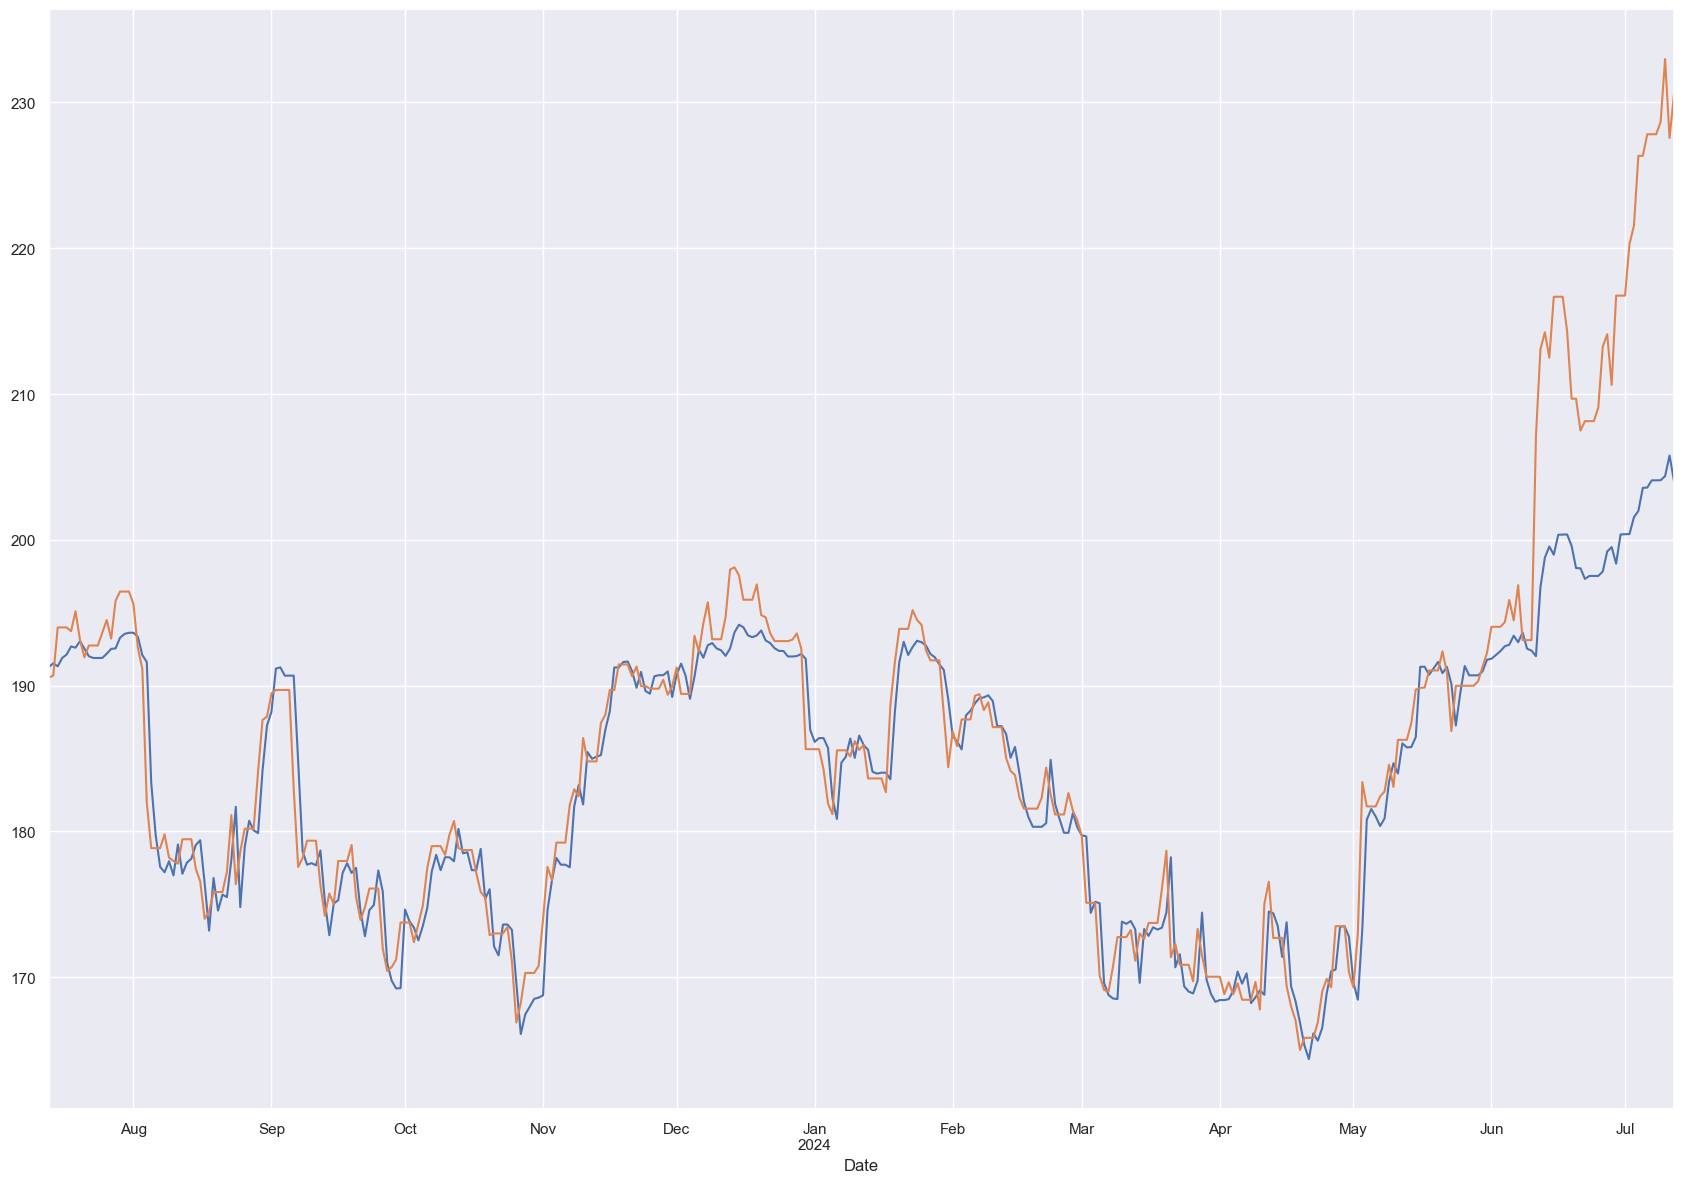

In [72]:
vot_predictions_df.plot() 
test_df.plot()

In [73]:
mean_absolute_percentage_error(test_df,vot_predictions_df)

0.015046021600836493

In [74]:

def test_voting_regressor(X_train, y_train, X_test, y_test):
    # List of possible regressor classes
    regressors = [
        ('lr', LinearRegression()),
        ('dt', DecisionTreeRegressor()),
        ('knn', KNeighborsRegressor()),
        ('rf', RandomForestRegressor()),
        ('svr', SVR()),
        ('mlp', MLPRegressor(max_iter=1000))
    ]
    
    # Initialize and fit the VotingRegressor with all possible combinations of 3 regressors
    best_mape = float('inf')
    best_combination = None
    best_predictions = None
    
    from itertools import combinations
    for comb in combinations(regressors, 3):
        voting_regressor = VotingRegressor(estimators=list(comb))  # Convert tuple to list
        voting_regressor.fit(X_train, y_train)
        predictions = voting_regressor.predict(X_test)
        vot_predictions_df = pd.Series(index=pd.date_range(start='2023-07-13', end='2024-07-12'), data=predictions)
        mape = mean_absolute_percentage_error(y_test, vot_predictions_df)
        print(f"Combination: {[est[0] for est in comb]}, MAPE: {mape}")
        
        if mape < best_mape:
            best_mape = mape
            best_combination = comb
            best_predictions = vot_predictions_df
    
    print(f"\nBest combination: {[est[0] for est in best_combination]}, Best MAPE: {best_mape}")
    return best_combination, best_predictions, best_mape

In [75]:
test_voting_regressor(X_train,y_train,X_test,y_test)

Combination: ['lr', 'dt', 'knn'], MAPE: 0.015167764026079361
Combination: ['lr', 'dt', 'rf'], MAPE: 0.015233817412703013
Combination: ['lr', 'dt', 'svr'], MAPE: 0.033850179871094656
Combination: ['lr', 'dt', 'mlp'], MAPE: 0.010817531996110031
Combination: ['lr', 'knn', 'rf'], MAPE: 0.014488407769274866
Combination: ['lr', 'knn', 'svr'], MAPE: 0.03367758568881845
Combination: ['lr', 'knn', 'mlp'], MAPE: 0.010500224458028572
Combination: ['lr', 'rf', 'svr'], MAPE: 0.033496627268683396
Combination: ['lr', 'rf', 'mlp'], MAPE: 0.01053648334668135
Combination: ['lr', 'svr', 'mlp'], MAPE: 0.029473708319371194
Combination: ['dt', 'knn', 'rf'], MAPE: 0.019752727748742663
Combination: ['dt', 'knn', 'svr'], MAPE: 0.03816697386878118
Combination: ['dt', 'knn', 'mlp'], MAPE: 0.014753672480656264
Combination: ['dt', 'rf', 'svr'], MAPE: 0.038273459299261625
Combination: ['dt', 'rf', 'mlp'], MAPE: 0.01501320621323623
Combination: ['dt', 'svr', 'mlp'], MAPE: 0.03416918990521562
Combination: ['knn', 'rf

((('lr', LinearRegression()),
  ('knn', KNeighborsRegressor()),
  ('mlp', MLPRegressor(max_iter=1000))),
 2023-07-13   190.00
 2023-07-14   190.52
 2023-07-15   190.91
 2023-07-16   193.05
 2023-07-17   193.38
               ...  
 2024-07-08   216.08
 2024-07-09   216.11
 2024-07-10   216.64
 2024-07-11   219.32
 2024-07-12   216.12
 Freq: D, Length: 366, dtype: float64,
 0.010500224458028572)

In [76]:
X_test 

close_1d_before  close_2d_before  close_3d_before
Date                                                         
2023-07-13           189.77           188.08           188.61
2023-07-14           190.54           189.77           188.08
2023-07-15           190.69           190.54           189.77
2023-07-16           193.99           190.69           190.54
2023-07-17           193.99           193.99           190.69
...                     ...              ...              ...
2024-07-08           227.82           227.82           226.34
2024-07-09           227.82           227.82           227.82
2024-07-10           228.68           227.82           227.82
2024-07-11           232.98           228.68           227.82
2024-07-12           227.57           232.98           228.68

[366 rows x 3 columns]

In [77]:
close_df.drop('EMA',axis=1,inplace=True)
close_df

close  close_1d_before  close_2d_before  close_3d_before
Date                                                                
2010-07-15   8.98             9.03             8.99             9.19
2010-07-16   8.93             8.98             9.03             8.99
2010-07-17   8.77             8.93             8.98             9.03
2010-07-18   8.77             8.77             8.93             8.98
2010-07-19   8.77             8.77             8.77             8.93
...           ...              ...              ...              ...
2024-07-08 227.82           227.82           227.82           226.34
2024-07-09 228.68           227.82           227.82           227.82
2024-07-10 232.98           228.68           227.82           227.82
2024-07-11 227.57           232.98           228.68           227.82
2024-07-12 230.54           227.57           232.98           228.68

[5112 rows x 4 columns]

In [78]:
train_df

Date
2010-07-12     9.19
2010-07-13     8.99
2010-07-14     9.03
2010-07-15     8.98
2010-07-16     8.93
              ...  
2023-07-08   188.61
2023-07-09   188.61
2023-07-10   188.61
2023-07-11   188.08
2023-07-12   189.77
Freq: D, Name: close, Length: 4749, dtype: float64

In [79]:
bayesen_ridge_model=BayesianRidge()
mlp_model=MLPRegressor() 
bayesen_ridge_model.fit(close_df[:-366].drop(columns='close'),close_df['close'][:-366])
# mlp_model.fit(close_df[:-366].drop(columns='close'),close_df['close'][:-366])

BayesianRidge()

In [80]:
close_df.index[-1]

Timestamp('2024-07-12 00:00:00')

In [81]:
##

In [92]:



n_future_days = 366
def evaluate_model(model):
    
    model_1=model
    model_1.fit(close_df[:-366].drop(columns='close'),close_df['close'][:-366])
    
    # Get the last known data point
    last_known = close_df[:-366].iloc[-1]
    
    # Prepare a data frame to hold future predictions
    future_dates = pd.date_range(start=close_df[:-366].index[-1] + pd.Timedelta(days=1), periods=n_future_days, freq='D')
    future_df = pd.DataFrame(index=future_dates, columns=['close', 'close_1d_before', 'close_2d_before', 'close_3d_before'])
    
    # Populate the initial lagged values
    future_df.iloc[0, 1:] = last_known[['close', 'close_1d_before', 'close_2d_before']]
    
    # Iteratively predict future values
    for i in range(n_future_days):
        if i == 0:
            features = future_df.iloc[i, 1:].values.reshape(1, -1)
        else:
            future_df.iloc[i, 1:] = future_df.iloc[i-1, :3].values
            features = future_df.iloc[i, 1:].values.reshape(1, -1)
    
        future_df.iloc[i, 0] = model_1.predict(features)[0]
    
    # Display the future predictions
    print('MAPE:\n')
    print(mean_absolute_percentage_error(future_df['close'],test_df))

In [83]:
evaluate_model(LinearRegression())

MAPE:

0.09930803191107158


In [84]:
evaluate_model(Lasso())

MAPE:

0.0684489750190387


In [85]:
evaluate_model(RandomForestRegressor())

MAPE:

0.05740003612886989


In [86]:
evaluate_model(DecisionTreeRegressor())

MAPE:

0.05889588480282962


In [87]:
from sklearn.svm import LinearSVR
evaluate_model(LinearSVR())

MAPE:

0.06914731106655289


In [88]:
evaluate_model(SVR())

MAPE:

0.11766747318506146


In [89]:
evaluate_model(Ridge())

MAPE:

0.09930688017373791


### creating future df using  Decision Tree

In [198]:
dt_model=DecisionTreeRegressor() 
dt_model.fit(close_df.drop(columns='close'),close_df['close'])
    
# Get the last known data point
last_known = close_df.iloc[-1]
n_future_days=1098
# Prepare a data frame to hold future predictions
future_dates = pd.date_range(start=close_df.index[-1] + pd.Timedelta(days=1), periods=n_future_days, freq='D')
future_df = pd.DataFrame(index=future_dates, columns=['close', 'close_1d_before', 'close_2d_before', 'close_3d_before'])

# Populate the initial lagged values
future_df.iloc[0, 1:] = last_known[['close', 'close_1d_before', 'close_2d_before']]

# Iteratively predict future values
for i in range(n_future_days):
    if i == 0:
        features = future_df.iloc[i, 1:].values.reshape(1, -1)
    else:
        future_df.iloc[i, 1:] = future_df.iloc[i-1, :3].values
        features = future_df.iloc[i, 1:].values.reshape(1, -1)

    future_df.iloc[i, 0] = dt_model.predict(features)[0]


In [204]:
future_df['close']

2024-07-13   232.98
2024-07-14   227.57
2024-07-15   230.54
2024-07-16   232.98
2024-07-17   227.57
              ...  
2027-07-11   227.57
2027-07-12   230.54
2027-07-13   232.98
2027-07-14   227.57
2027-07-15   230.54
Freq: D, Name: close, Length: 1098, dtype: object

<Axes: xlabel='Date'>

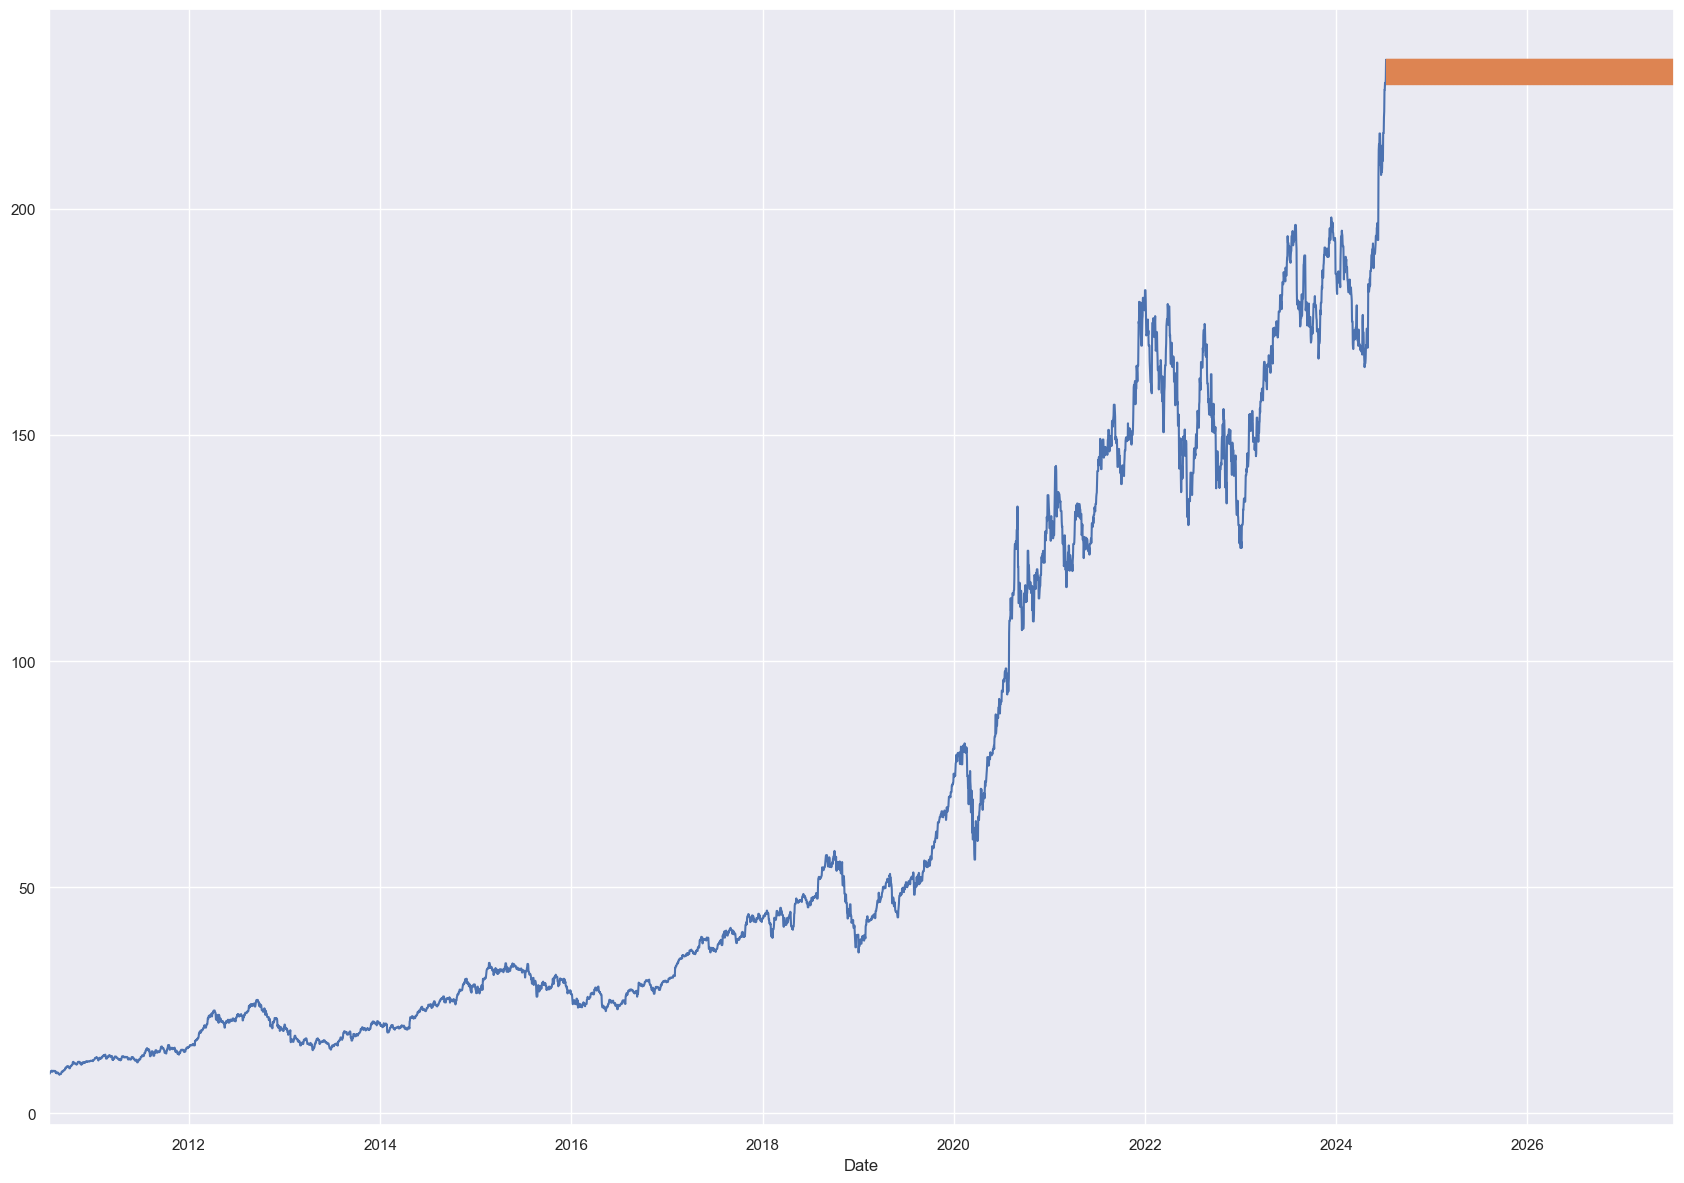

In [206]:
close_df['close'].plot()
future_df['close'].plot() 

### Creating future df with lasso 

In [207]:
lasso=Lasso() 
lasso.fit(close_df.drop(columns='close'),close_df['close'])
    
# Get the last known data point
last_known = close_df.iloc[-1]
n_future_days=1098
# Prepare a data frame to hold future predictions
future_dates = pd.date_range(start=close_df.index[-1] + pd.Timedelta(days=1), periods=n_future_days, freq='D')
future_df = pd.DataFrame(index=future_dates, columns=['close', 'close_1d_before', 'close_2d_before', 'close_3d_before'])

# Populate the initial lagged values
future_df.iloc[0, 1:] = last_known[['close', 'close_1d_before', 'close_2d_before']]

# Iteratively predict future values
for i in range(n_future_days):
    if i == 0:
        features = future_df.iloc[i, 1:].values.reshape(1, -1)
    else:
        future_df.iloc[i, 1:] = future_df.iloc[i-1, :3].values
        features = future_df.iloc[i, 1:].values.reshape(1, -1)

    future_df.iloc[i, 0] = lasso.predict(features)[0]


<Axes: xlabel='Date'>

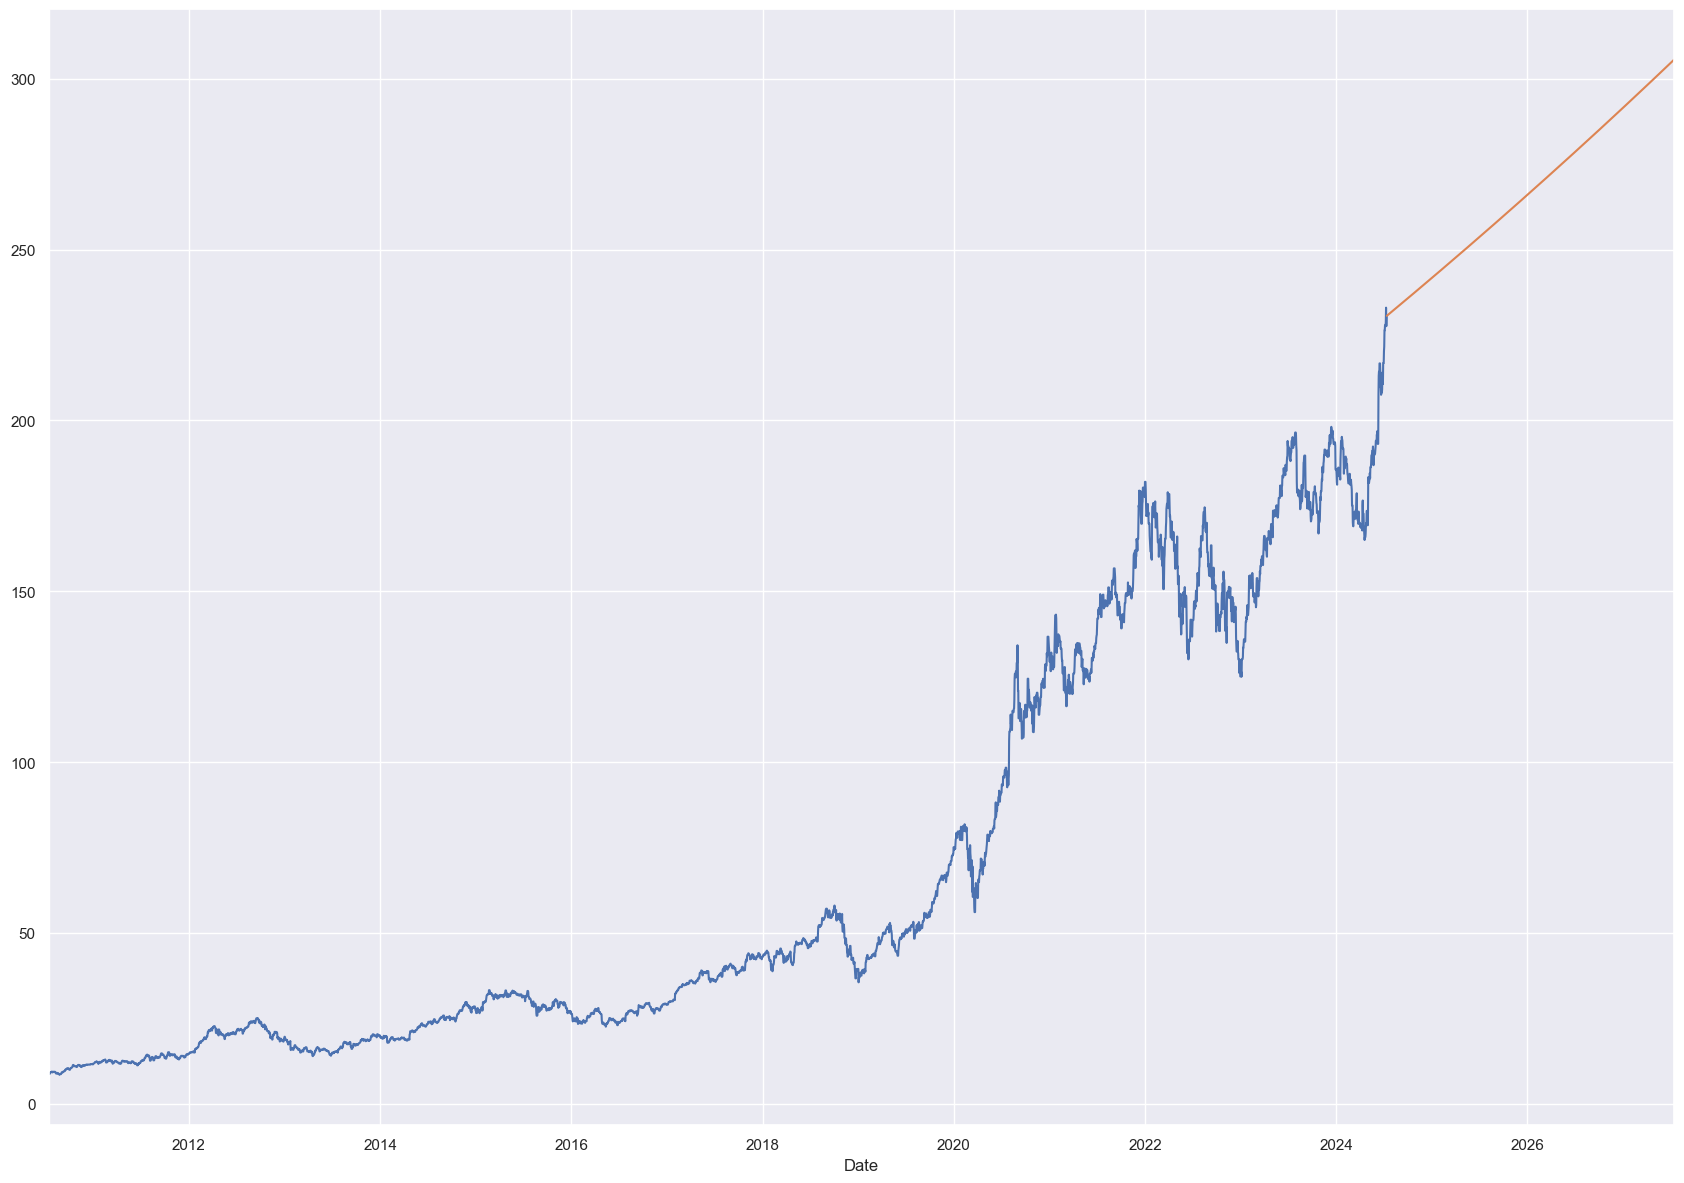

In [208]:
close_df['close'].plot()
future_df['close'].plot() 

## FBProphet 

In [96]:
prophet_df=close_df['close']
prophet_df=pd.DataFrame(prophet_df)
prophet_df['Date']=prophet_df.index
prophet_df.columns=['y','ds']
prophet_df

y         ds
Date                        
2010-07-15   8.98 2010-07-15
2010-07-16   8.93 2010-07-16
2010-07-17   8.77 2010-07-17
2010-07-18   8.77 2010-07-18
2010-07-19   8.77 2010-07-19
...           ...        ...
2024-07-08 227.82 2024-07-08
2024-07-09 228.68 2024-07-09
2024-07-10 232.98 2024-07-10
2024-07-11 227.57 2024-07-11
2024-07-12 230.54 2024-07-12

[5112 rows x 2 columns]

In [98]:
prophet_df.dtypes

y            float64
ds    datetime64[ns]
dtype: object

In [99]:
train_prophet_df=prophet_df[:-366]
test_prophet_df=prophet_df[-366:]
test_prophet_df

y         ds
Date                        
2023-07-13 190.54 2023-07-13
2023-07-14 190.69 2023-07-14
2023-07-15 193.99 2023-07-15
2023-07-16 193.99 2023-07-16
2023-07-17 193.99 2023-07-17
...           ...        ...
2024-07-08 227.82 2024-07-08
2024-07-09 228.68 2024-07-09
2024-07-10 232.98 2024-07-10
2024-07-11 227.57 2024-07-11
2024-07-12 230.54 2024-07-12

[366 rows x 2 columns]

In [101]:
from prophet import Prophet 
prophet_model=Prophet() 
prophet_model.fit(train_prophet_df)
future = prophet_model.make_future_dataframe(periods=366, freq='D') 
forecast = prophet_model.predict(future)



05:26:06 - cmdstanpy - INFO - Chain [1] start processing
05:26:07 - cmdstanpy - INFO - Chain [1] done processing


In [114]:
future

ds
0    2010-07-15
1    2010-07-16
2    2010-07-17
3    2010-07-18
4    2010-07-19
...         ...
5107 2024-07-08
5108 2024-07-09
5109 2024-07-10
5110 2024-07-11
5111 2024-07-12

[5112 rows x 1 columns]

In [102]:
forecast

ds  trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2010-07-15   7.97       -0.93       17.13         7.97         7.97   
1    2010-07-16   7.99        0.02       17.84         7.99         7.99   
2    2010-07-17   8.01       -0.63       18.01         8.01         8.01   
3    2010-07-18   8.02       -0.66       17.36         8.02         8.02   
4    2010-07-19   8.04       -0.61       17.39         8.04         8.04   
...         ...    ...         ...         ...          ...          ...   
5107 2024-07-08 183.52      170.64      196.79       173.05       194.01   
5108 2024-07-09 183.56      170.59      198.55       173.08       194.10   
5109 2024-07-10 183.60      171.16      197.64       173.11       194.19   
5110 2024-07-11 183.64      170.02      197.91       173.12       194.30   
5111 2024-07-12 183.68      171.40      197.52       173.09       194.41   

      additive_terms  additive_terms_lower  additive_terms_upper  weekly  \
0               0.36                  0.36                  0.36   -0.03   
1               0.34                  0.34                  0.34   -0.03   
2               0.38                  0.38                  0.38    0.02   
3               0.33                  0.33                  0.33   -0.01   
4               0.28                  0.28                  0.28   -0.05   
...              ...                   ...                   ...     ...   
5107            0.34                  0.34                  0.34   -0.05   
5108            0.43                  0.43                  0.43    0.02   
5109            0.49                  0.49                  0.49    0.07   
5110            0.39                  0.39                  0.39   -0.03   
5111            0.38                  0.38                  0.38   -0.03   

      weekly_lower  weekly_upper  yearly  yearly_lower  yearly_upper  \
0            -0.03         -0.03    0.39          0.39          0.39   
1            -0.03         -0.03    0.37          0.37          0.37   
2             0.02          0.02    0.35          0.35          0.35   
3            -0.01         -0.01    0.34          0.34          0.34   
4            -0.05         -0.05    0.33          0.33          0.33   
...            ...           ...     ...           ...           ...   
5107         -0.05         -0.05    0.39          0.39          0.39   
5108          0.02          0.02    0.41          0.41          0.41   
5109          0.07          0.07    0.42          0.42          0.42   
5110         -0.03         -0.03    0.42          0.42          0.42   
5111         -0.03         -0.03    0.42          0.42          0.42   

      multiplicative_terms  multiplicative_terms_lower  \
0                     0.00                        0.00   
1                     0.00                        0.00   
2                     0.00                        0.00   
3                     0.00                        0.00   
4                     0.00                        0.00   
...                    ...                         ...   
5107                  0.00                        0.00   
5108                  0.00                        0.00   
5109                  0.00                        0.00   
5110                  0.00                        0.00   
5111                  0.00                        0.00   

      multiplicative_terms_upper   yhat  
0                           0.00   8.33  
1                           0.00   8.33  
2                           0.00   8.38  
3                           0.00   8.35  
4                           0.00   8.33  
...                          ...    ...  
5107                        0.00 183.87  
5108                        0.00 183.99  
5109                        0.00 184.09  
5110                        0.00 184.04  
5111                        0.00 184.07  

[5112 rows x 19 columns]

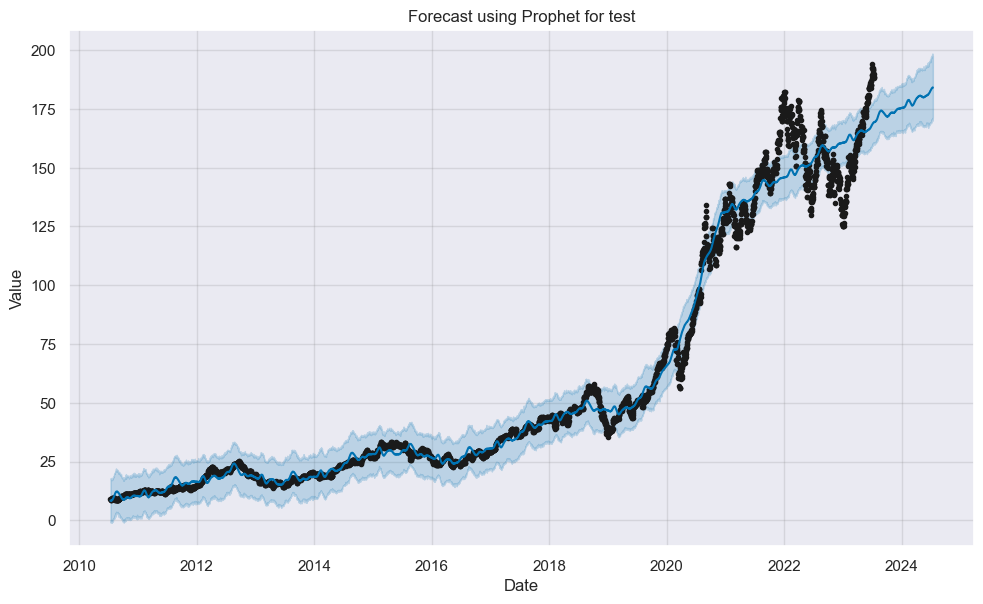

In [132]:
fig = prophet_model.plot(forecast)
plt.title('Forecast using Prophet for test')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [103]:
forecast_df=forecast[-366:][['ds','yhat']]
forecast_df

ds   yhat
4746 2023-07-13 169.32
4747 2023-07-14 169.34
4748 2023-07-15 169.43
4749 2023-07-16 169.42
4750 2023-07-17 169.41
...         ...    ...
5107 2024-07-08 183.87
5108 2024-07-09 183.99
5109 2024-07-10 184.09
5110 2024-07-11 184.04
5111 2024-07-12 184.07

[366 rows x 2 columns]

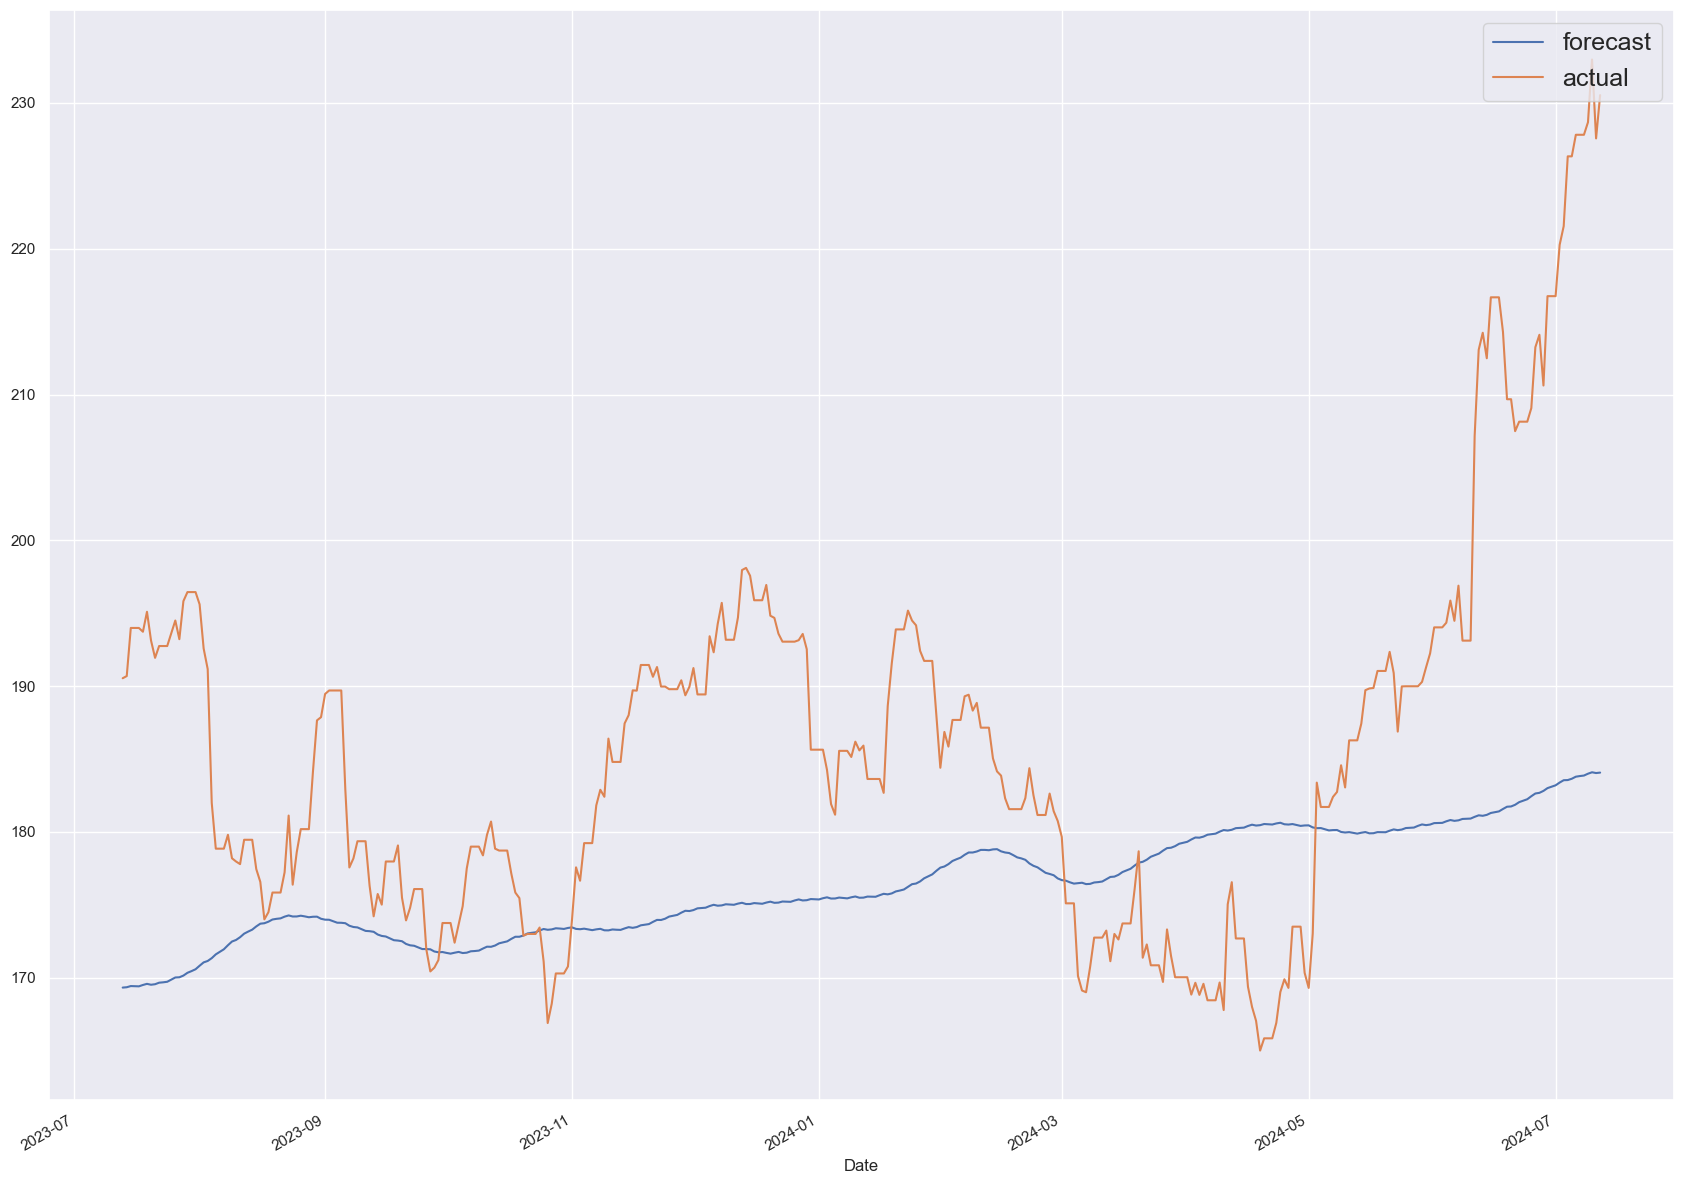

In [112]:
plt.plot(forecast_df['ds'],forecast_df['yhat'],label='forecast')
test_df.plot(label='actual')


plt.legend(loc='upper right', prop={'size': 18})

plt.show()

In [113]:
mean_absolute_percentage_error(test_df,forecast_df['yhat'])

0.06259936983913005

## forecasting using all df 

In [121]:
366*3

1098

In [128]:
prophet_model_1=Prophet() 
prophet_model_1.fit(prophet_df)
future_1 = prophet_model_1.make_future_dataframe(periods=1098, freq='D') 
forecast_1 = prophet_model_1.predict(future_1)



05:41:42 - cmdstanpy - INFO - Chain [1] start processing
05:41:46 - cmdstanpy - INFO - Chain [1] done processing


In [129]:
forecast_1

ds  trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2010-07-15   7.92        0.36       19.40         7.92         7.92   
1    2010-07-16   7.94        0.01       19.11         7.94         7.94   
2    2010-07-17   7.96        0.60       18.91         7.96         7.96   
3    2010-07-18   7.97        0.22       19.33         7.97         7.97   
4    2010-07-19   7.99        0.13       19.49         7.99         7.99   
...         ...    ...         ...         ...          ...          ...   
6205 2027-07-11 235.48      181.82      295.32       180.70       292.20   
6206 2027-07-12 235.52      183.59      295.46       180.66       292.32   
6207 2027-07-13 235.57      182.17      296.33       180.63       292.44   
6208 2027-07-14 235.61      181.52      297.88       180.59       292.56   
6209 2027-07-15 235.65      181.55      294.51       180.56       292.69   

      additive_terms  additive_terms_lower  additive_terms_upper  weekly  \
0               2.21                  2.21                  2.21   -0.01   
1               2.18                  2.18                  2.18   -0.01   
2               2.16                  2.16                  2.16    0.01   
3               2.08                  2.08                  2.08   -0.02   
4               2.00                  2.00                  2.00   -0.06   
...              ...                   ...                   ...     ...   
6205            2.26                  2.26                  2.26   -0.02   
6206            2.22                  2.22                  2.22   -0.06   
6207            2.29                  2.29                  2.29    0.02   
6208            2.32                  2.32                  2.32    0.07   
6209            2.22                  2.22                  2.22   -0.01   

      weekly_lower  weekly_upper  yearly  yearly_lower  yearly_upper  \
0            -0.01         -0.01    2.22          2.22          2.22   
1            -0.01         -0.01    2.18          2.18          2.18   
2             0.01          0.01    2.15          2.15          2.15   
3            -0.02         -0.02    2.11          2.11          2.11   
4            -0.06         -0.06    2.06          2.06          2.06   
...            ...           ...     ...           ...           ...   
6205         -0.02         -0.02    2.28          2.28          2.28   
6206         -0.06         -0.06    2.28          2.28          2.28   
6207          0.02          0.02    2.27          2.27          2.27   
6208          0.07          0.07    2.25          2.25          2.25   
6209         -0.01         -0.01    2.23          2.23          2.23   

      multiplicative_terms  multiplicative_terms_lower  \
0                     0.00                        0.00   
1                     0.00                        0.00   
2                     0.00                        0.00   
3                     0.00                        0.00   
4                     0.00                        0.00   
...                    ...                         ...   
6205                  0.00                        0.00   
6206                  0.00                        0.00   
6207                  0.00                        0.00   
6208                  0.00                        0.00   
6209                  0.00                        0.00   

      multiplicative_terms_upper   yhat  
0                           0.00  10.13  
1                           0.00  10.12  
2                           0.00  10.12  
3                           0.00  10.06  
4                           0.00   9.99  
...                          ...    ...  
6205                        0.00 237.74  
6206                        0.00 237.74  
6207                        0.00 237.86  
6208                        0.00 237.93  
6209                        0.00 237.87  

[6210 rows x 19 columns]

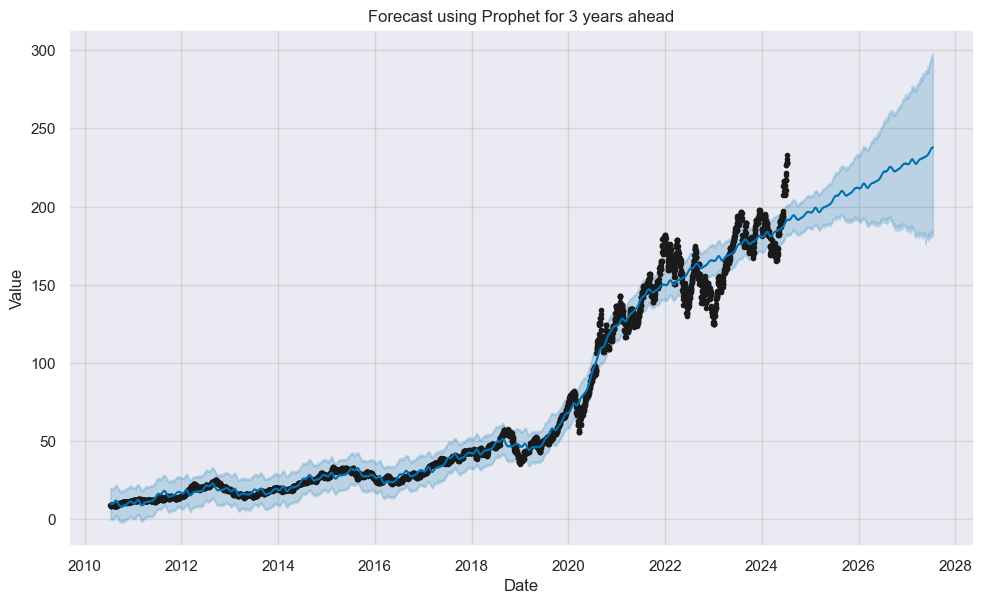

In [131]:
fig_1=prophet_model_1.plot(forecast_1)
plt.title('Forecast using Prophet for 3 years ahead')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [133]:
forecast_df_1=forecast_1[['ds','yhat']]
forecast_df_1

ds   yhat
0    2010-07-15  10.13
1    2010-07-16  10.12
2    2010-07-17  10.12
3    2010-07-18  10.06
4    2010-07-19   9.99
...         ...    ...
6205 2027-07-11 237.74
6206 2027-07-12 237.74
6207 2027-07-13 237.86
6208 2027-07-14 237.93
6209 2027-07-15 237.87

[6210 rows x 2 columns]

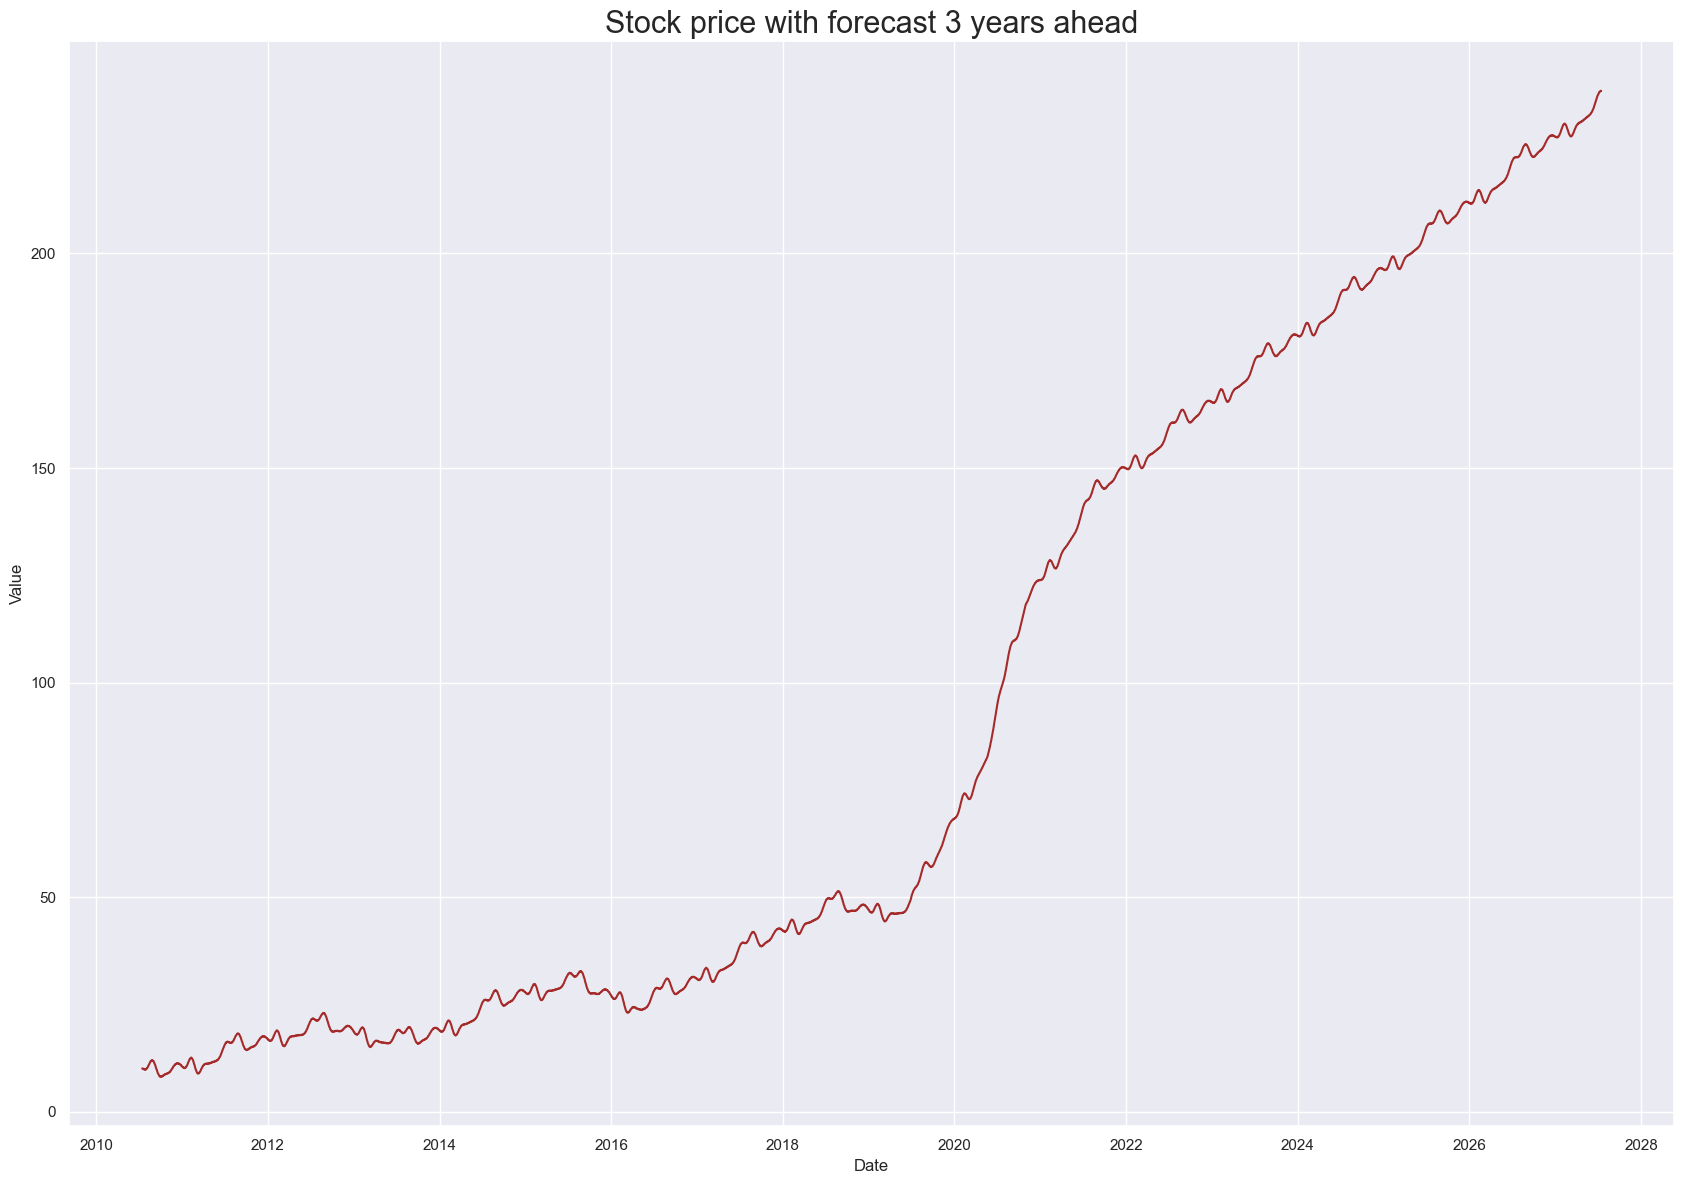

In [141]:
plt.plot(forecast_df_1['ds'],forecast_df_1['yhat'],color='brown')

plt.title('Stock price with forecast 3 years ahead',fontsize=22)
plt.xlabel('Date')
plt.ylabel('Value')

plt.show()


In [142]:
forecast_df_1

ds   yhat
0    2010-07-15  10.13
1    2010-07-16  10.12
2    2010-07-17  10.12
3    2010-07-18  10.06
4    2010-07-19   9.99
...         ...    ...
6205 2027-07-11 237.74
6206 2027-07-12 237.74
6207 2027-07-13 237.86
6208 2027-07-14 237.93
6209 2027-07-15 237.87

[6210 rows x 2 columns]

In [143]:
future_close_data=forecast_df_1[-1098:]
future_close_data

ds   yhat
5112 2024-07-13 191.48
5113 2024-07-14 191.47
5114 2024-07-15 191.44
5115 2024-07-16 191.53
5116 2024-07-17 191.58
...         ...    ...
6205 2027-07-11 237.74
6206 2027-07-12 237.74
6207 2027-07-13 237.86
6208 2027-07-14 237.93
6209 2027-07-15 237.87

[1098 rows x 2 columns]

In [149]:
future_close_data.dtypes

ds      datetime64[ns]
yhat           float64
dtype: object

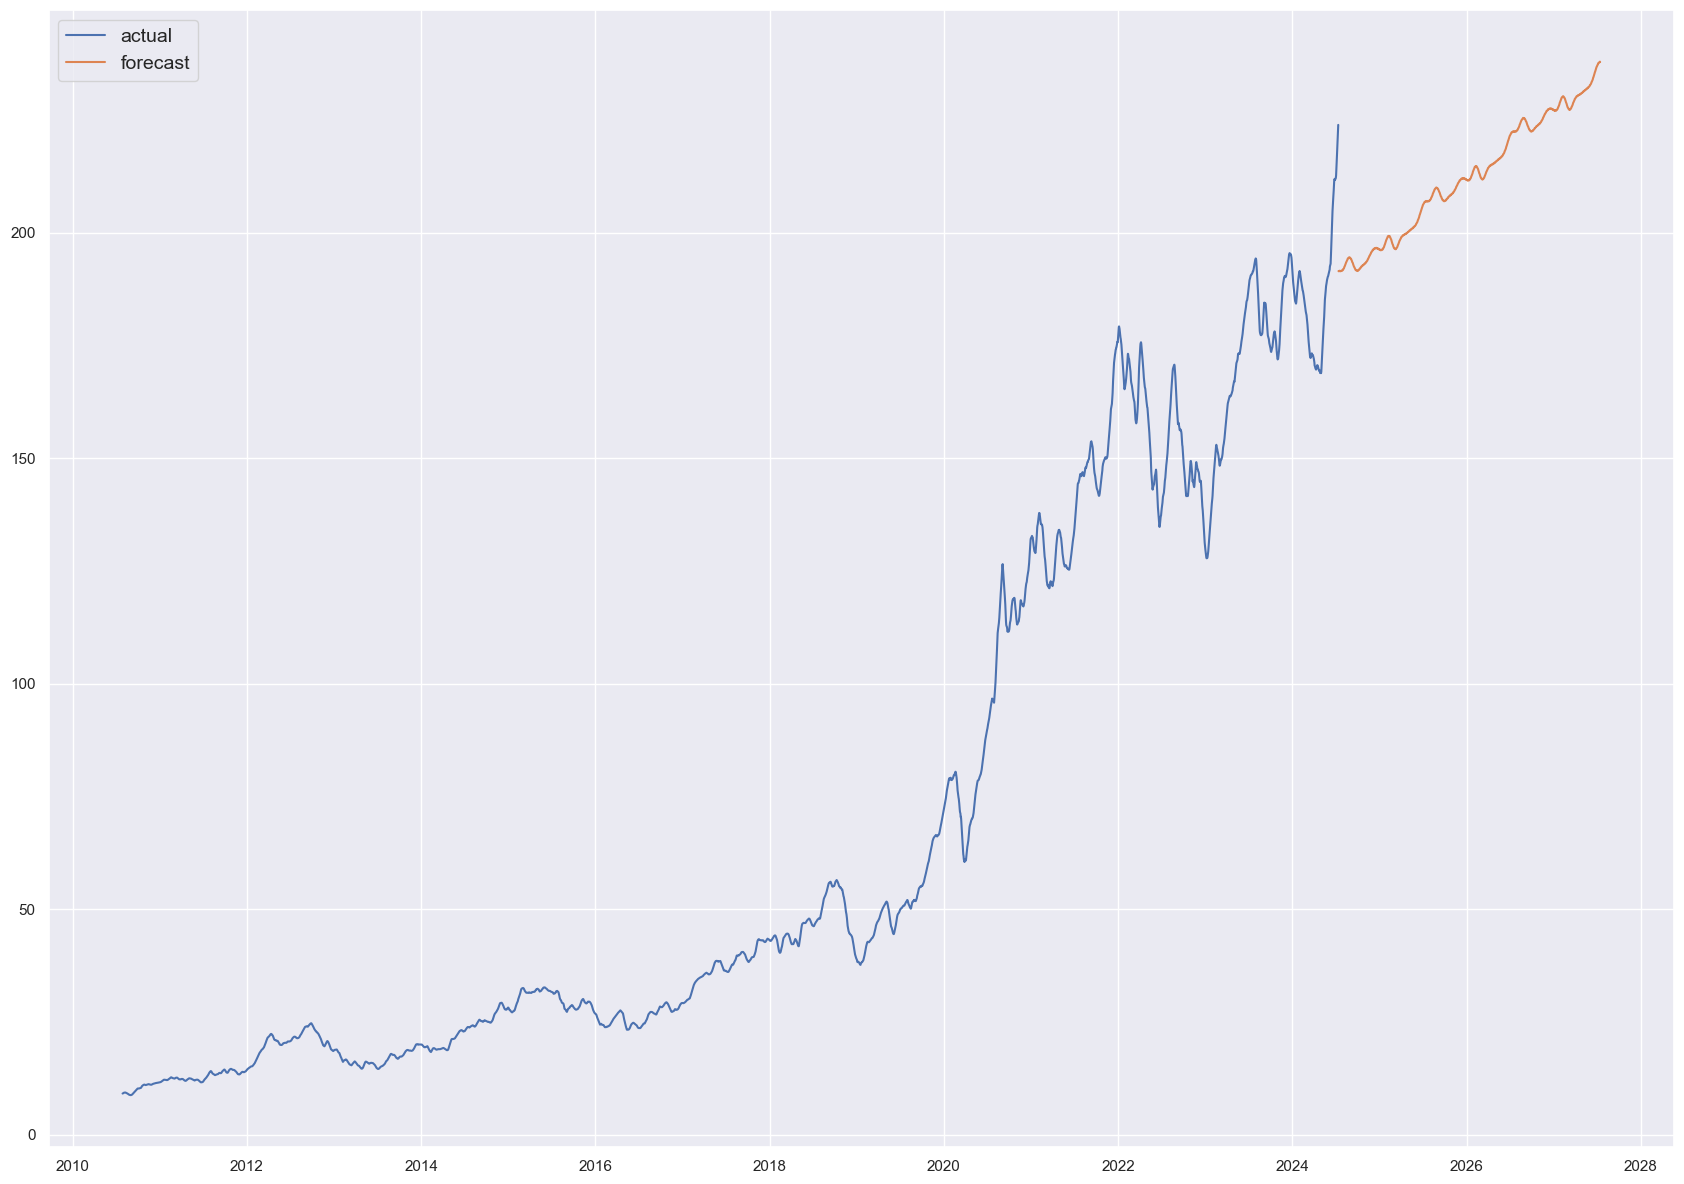

In [153]:
plt.plot(close_df.index,close_df['close'].rolling(15).mean(),label='actual') 
plt.plot(future_close_data['ds'],future_close_data['yhat'],label='forecast')
plt.legend(prop={'size':14},loc='upper left')
plt.show()

In [178]:
import pickle  
future_close_data.columns=['date','close']
future_close_data

date  close
5112 2024-07-13 191.48
5113 2024-07-14 191.47
5114 2024-07-15 191.44
5115 2024-07-16 191.53
5116 2024-07-17 191.58
...         ...    ...
6205 2027-07-11 237.74
6206 2027-07-12 237.74
6207 2027-07-13 237.86
6208 2027-07-14 237.93
6209 2027-07-15 237.87

[1098 rows x 2 columns]

In [180]:
pickle.dump(future_close_data,open('future_close_data_prophet.pkl','wb'))